In [2]:
## delRosario_Mason_project.py
# Author: Mason del Rosario
# Spring 2019

# call libs
import json
import os
import math
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import stats
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pandas as pd

In [69]:
def project_main(filename,params):
    # unpack params
    bin_sizes = params['bin_sizes']
    t_pre = params['t_pre']
    t_post = params['t_post']

    # load data
    # -> https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
    with open(filename) as json_file:
        data=json.load(json_file)
    events=data['events']
    neurons=data['neurons']

    # binning based on pseudocode
    bin_dict={'t_bin':dict()}
    dummy=10e8 # placeholder to-be-deleted in construction of raster histograms

    for bin_size in bin_sizes:
        # generate t_bins
        t_bin = np.arange(t_pre, t_post+1, bin_size).tolist()
        bin_dict['t_bin'][str(bin_size)]=t_bin
        print('bin_size: %s' % str(bin_size))
        # pre-populate output array per-bin
        out=dict()
        i=0
        for event_name, event_data in events.items(): 
            for event in event_data:
                out['{:03d}'.format(i)]={'Y':[]}
                i=i+1
        i=0 # trial # index
        i_init=0 # trial # to sweep
        for event_name, event_data in events.items():
            for neuron_name, neuron_data in neurons.items():
                # sort binned responses by trial of dim time bins (rows) x neurons (cols) [might be transposed?]
                i=i_init
                for event_ts in event_data:
#                     print('event: {} - neuron: {} - i: {}'.format(event_name, neuron_name, i))
                    offset_ts = [1000*(neuron_ts - event_ts) for neuron_ts in neuron_data] # neural response
                    binned_response, bins = np.histogram(offset_ts, bins=t_bin) # single trial histogram
                    binned_aggregate=out['{:03d}'.format(i)]['Y']
                    if type(binned_aggregate) == list:
                        binned_aggregate = np.array([binned_response])
                    else:
                        binned_aggregate = np.vstack((binned_aggregate,np.array([binned_response])))
                    out['{:03d}'.format(i)]['Y']=binned_aggregate
                    i=i+1 # increment trial # index
            i_init=i_init+len(event_data)

        for i in range(i_init):
            out['{:03d}'.format(i)]=binned_aggregate.tolist()
        trial_dur=t_post-t_pre
        bin_dict[str(bin_size)]={
                            'data': out,
                            'trialDur':trial_dur,
                            'T':trial_dur/bin_size,
                            'binSize':bin_size,
                            'numTrials':i_init
                           }

    print('Binned Responses Generated.')
    return [bin_dict,events,neurons]

In [6]:
def plot_binned_resp(bin_dict,events,neurons,params):

    bin_sizes=params['bin_sizes']
    for event_name, event_data in events.items():
        for neuron_name, neuron_data in neurons.items(): 
            # Plot event_3, sig003a raster
            plt.figure(figsize=(fig_width,fig_height))
            plt.title('%s - %s'%(event_name,neuron_name), fontsize=14)
            plt.eventplot(bin_dict[min(bin_sizes)][event_name][neuron_name]['trains'])
            plt.xlabel('Time [ms]')
            plt.ylabel('Trial #')
            plt.savefig(filename_prefix+'-raster-%s-%s.png'%(event_name,neuron_name))

In [7]:
def gen_psth(bin_dict,events,neurons,params,fig_params):
    # PSTH construction
    bin_sizes=params['bin_sizes']
    fig_width=fig_params['fig_width']
    fig_height=fig_params['fig_height']
    psth_dict=dict()
    for bin_size in bin_sizes:
        psth_dict[bin_size]=dict()
        for event_name, event_data in events.items():
                psth_dict[bin_size][event_name]=dict()
                for neuron_name, neuron_data in neurons.items():
                    psth_dict[bin_size][event_name][neuron_name]=[]
    for bin_size in bin_sizes:
        for event_name, event_data in events.items():
                i=0
                # generate groud-truth psth per neuron (all trials) # psth dim = 1 row x (N x B) cols
                for neuron_name, neuron_data in neurons.items():
                    n_trial=bin_dict[bin_size][event_name][neuron_name]['num_trials']
                    psth=bin_dict[bin_size][event_name][neuron_name]['psth'] 
                    weights=np.ones(psth.size)/n_trial
                    bin_vals,bins=np.histogram(psth,bins=bin_dict['t_bin'][bin_size],weights=weights)
                    bin_vals=bin_vals.tolist() 
                    psth_dict[bin_size][event_name][neuron_name]=bin_vals
                    # build out psth_dict entry of desired format
                    if i==0:
                        psth_dict[bin_size][event_name]['template'] = bin_vals 
                    elif i>0:
                        psth_dict[bin_size][event_name]['template'] = np.concatenate((psth_dict[bin_size][event_name]['template'],bin_vals),axis=None)
                    i=i+1
#                     # generate leave-one-out psths and corresponding templates
#                     print("{} - {} - {}: trials".format(bin_size,event_name, neuron_name))
#                     j=0
#                     print("->psth: {}".format(psth))
#                     for trial in psth:
#                         print("Trial {} -> {}".format(j,trial))
#                         j=j+1

    return psth_dict

In [8]:
def gen_single_trial_psths(bin_dict,events,neurons,params):
    # create single-trial psths and leave-one-out templates
    bin_sizes=params['bin_sizes']
    leave_out_dict = dict()
    for bin_size in bin_sizes:
        print('bin_size: {}'.format(bin_size))
        t_bin=bin_dict['t_bin'][bin_size] # time vector to demarcate bins for given bin size
        leave_out_dict[bin_size]=dict()
        for event_name, event_data in events.items():
            print('-> {}'.format(event_name))
            leave_out_dict[bin_size][event_name]=dict()
            # bins are organized by event->neuron: aggregate them into desired format
            i=0 # track neuron index
            for neuron_name, neuron_data in neurons.items():
                n_trial=bin_dict[bin_size][event_name][neuron_name]['num_trials']
                trains=bin_dict[bin_size][event_name][neuron_name]['trains']
                bins=bin_dict[bin_size][event_name][neuron_name]['bins']
                j=0 # track trial index
                # iterate through rows of bins/trials
                for trial in bins:
                    # generate template for current event/neuron (base on current trial index: j)
                    zeros_temp=np.zeros(len(trial))
                    trial=gen_template_psth(np.vstack((zeros_temp,trial)),2,t_bin)
                    if j==0:  
                        # leave_out_dict[event_name][i]['template']=gen_template_psth(trains,j)
                        #untested corner case
                        template=gen_template_psth(bins[1:len(bins)],n_trial,t_bin)
                    elif j<len(bins)-1:
                        split_bins=np.split(bins,[0,j,len(bins)])
                        template=gen_template_psth(np.concatenate((split_bins[0],split_bins[2]),axis=0),n_trial,t_bin)
                    else:
                        #untested corner case
                        template=gen_template_psth(bins[0:len(bins)-1],n_trial,t_bin)
                    # append template to leave_out_dict (base on neuron index: i)
                    if i==0:
                        leave_out_dict[bin_size][event_name][j]=dict()
                        leave_out_dict[bin_size][event_name][j]['single_trial']=trial
                        leave_out_dict[bin_size][event_name][j]['template']=template
                    else:
                        leave_out_dict[bin_size][event_name][j]['single_trial']=np.concatenate((leave_out_dict[bin_size][event_name][j]['single_trial'],trial),axis=None)
                        leave_out_dict[bin_size][event_name][j]['template']=np.concatenate((leave_out_dict[bin_size][event_name][j]['template'],template),axis=None)
                    j=j+1
                i=i+1
    return leave_out_dict
    
def gen_template_psth(bins,n_trial,t_bin):
    # generate template psth
    dummy=10e8 # placeholder to-be-deleted in construction of raster histograms
    j=0
    for binned_response in bins:
        binned_response = np.array([[int(t_bin[i]) if binned_response[i]>=1 else dummy for i in range(len(t_bin)-1)]])
        indices = np.argwhere(binned_response==dummy)
        binned_response = np.delete(binned_response,indices)
        weights=np.ones(binned_response.size)/(n_trial-1)
        bin_vals,bins=np.histogram(binned_response,bins=t_bin,weights=weights)
#         bin_vals=bin_vals.tolist()
        if j==0:
            psth=bin_vals
        else:
            psth=np.sum((psth,bin_vals),axis=0)
        j=j+1
#         psth_dict[bin_size][event_name][neuron_name]=bin_vals
    return psth
        

In [9]:
def event_labels(psth_dict,leave_out_dict,events,neurons,params):
    # unpack params
    bin_sizes = params['bin_sizes']
    t_pre = params['t_pre']
    t_post = params['t_post']
    
    # binning based on pseudocode
    bin_dict={'t_bin':dict()}
    dummy=10e8 # placeholder to-be-deleted in construction of raster histograms

    event_items = events.items()
    neuron_items = neurons.items()
    event_len=len(events)
    
    conf_matrices=dict() # function output
    performance_dict=dict()
    
    for bin_size in bin_sizes:
        conf_matrices[bin_size]=np.zeros((event_len,event_len))
        performance_dict[bin_size]=0
        total_labels=0
        correct_labels=0
        print('bin_size: %s' % str(bin_size))
        # build nparray of default event templates
        i=0
        for event_name, event_data in event_items:
            if i == 0:
                default_templates = psth_dict[bin_size][event_name]['template']
            else:
#                 default_templates = np.concatenate((default_templates,psth_dict[bin_size][event_name]['template']),axis=0)
                default_templates = np.hstack((default_templates,psth_dict[bin_size][event_name]['template']))
            i=i+1
        # label trials based on templates
        true_label=0 # index of true event label
        for event_name, event_data in event_items:
            for trial_key, trial_dict in leave_out_dict[bin_size][event_name].items():
                psth_trial=trial_dict['single_trial']
                psth_template=trial_dict['template']
                # swap template psth into default_templates
#                 print('default_templates: {}'.format(default_templates))
                test_templates=default_templates.copy()
#                 print('psth_template: {}'.format(psth_template))
                test_templates[true_label]=psth_template
                classified_label=euclidian_dist_min(psth_trial,test_templates)
                # increment element in confusioin matrix
                conf_matrices[bin_size][true_label][classified_label]=conf_matrices[bin_size][true_label][classified_label]+1
                if classified_label == true_label:
                    correct_labels=correct_labels+1
                total_labels=total_labels+1
            true_label=true_label+1
        performance_dict[bin_size]=correct_labels/total_labels
                        
    return [conf_matrices,performance_dict]

def euclidian_dist_min(psth_trial, psth_templates):
    # calculate event index minimizing euclidian distance (L2 norm) between psths
    norm_vals=np.zeros(len(psth_templates))
    i = 0
    for template in psth_templates:
        norm_vals[i]=distance.euclidean(psth_trial, template)
        i=i+1
    min_ind=np.argmin(norm_vals)
    return min_ind

In [10]:
def mut_info_from_conf(conf_matrices,params):
    # calculate mutual information from confusion matrices
    bin_sizes = params['bin_sizes']
    prob_dict=dict()
    for bin_size in bin_sizes:
        print('bin_size: {}'.format(bin_size))
        prob_dict[bin_size]=dict()
        prob_dict[bin_size]
        total_trials=np.sum(conf_matrices[bin_size])
        p_rs=conf_matrices[bin_size].copy()/total_trials
        p_s=np.sum(conf_matrices[bin_size].copy(),axis=0)/total_trials
        p_r=np.sum(conf_matrices[bin_size].copy(),axis=1)/total_trials
        mut_info=0
        for p_r_index in range(len(p_r)):
            for p_s_index in range(len(p_s)):
                p_rs_ij=p_rs[p_r_index][p_s_index]
                # account for div by 0 errors
                if p_rs_ij != 0:
                    p_r_i=p_r[p_r_index]
                    p_s_j=p_s[p_s_index]
                    mut_info=mut_info+p_rs_ij*np.log2(p_rs_ij/(p_r_i*p_s_j))
        print('-> mut_info: {}'.format(mut_info))
        # pack up outputs
        prob_dict[bin_size]['p_rs']=p_rs
        prob_dict[bin_size]['p_r']=p_r
        prob_dict[bin_size]['p_s']=p_s
        prob_dict[bin_size]['mut_info']=mut_info
    return prob_dict   
        

In [34]:
# if __name__ = "__main__":
bin_sizes = [5,50,200]
t_pre = -200 # [ms]
t_post = 200
params={'bin_sizes':bin_sizes,'t_pre':t_pre,'t_post':t_post}
fig_height=9
fig_width=16
fig_params={'fig_width':fig_width,'fig_height':fig_height}
filepath='.'
filename_prefix=filepath+'/'+'tilt'
filename=filename_prefix+'.json'

In [70]:
# generate binned responses
[bin_dict,events,neurons]=project_main(filename,params)

bin_size: 5
bin_size: 50
bin_size: 200
Binned Responses Generated.


In [71]:
# pass out params for GPFA
# print(bin_dict)
print('Total # of neurons: {}'.format(len(neurons)))
print('Total # of trials: {}'.format(len(bin_dict['5']['data'])))
print('Trials per event:')
for event_name, event_data in events.items():
    print('-> {} - {}'.format(event_name, len(event_data)))
# print(bin_dict['5'])
save=1
if (save):
    save_str='gpfa_inputs.json'
    jsonfile = open(save_str, "w")
    # magic happens here to make pretty-printed json
    jsonfile.write(json.dumps(bin_dict, indent=4, sort_keys=True))
    jsonfile.close()
    print('Output saved to %s' % save_str)

Total # of neurons: 29
Total # of trials: 300
Trials per event:
-> event_1 - 71
-> event_2 - 77
-> event_3 - 72
-> event_4 - 80
Output saved to gpfa_inputs.json


In [18]:
# aggregate relative responses
out=dict()
for bin_size in bin_sizes:
    out[bin_size]=dict()
    for event_name, event_date in events.items():
        out[bin_size][event_name]=dict()
        for neuron_name, neuron_date in neurons.items():
            out[bin_size][event_name][neuron_name]=bin_dict[bin_size][event_name][neuron_name]['bins'].tolist()
save=1
# print(out)
if (save):
    save_str='delRosario_Mason_hw4_rel_resp.json'
    jsonfile = open(save_str, "w")
    # magic happens here to make pretty-printed json
    jsonfile.write(json.dumps(out, indent=4, sort_keys=True))
    jsonfile.close()
    print('Output saved to %s' % save_str)

Output saved to delRosario_Mason_hw4_rel_resp.json


C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


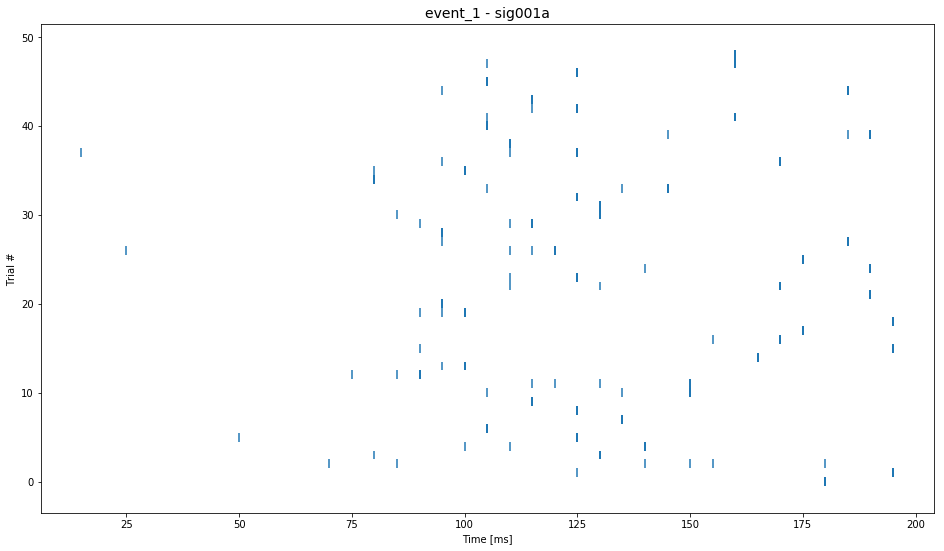

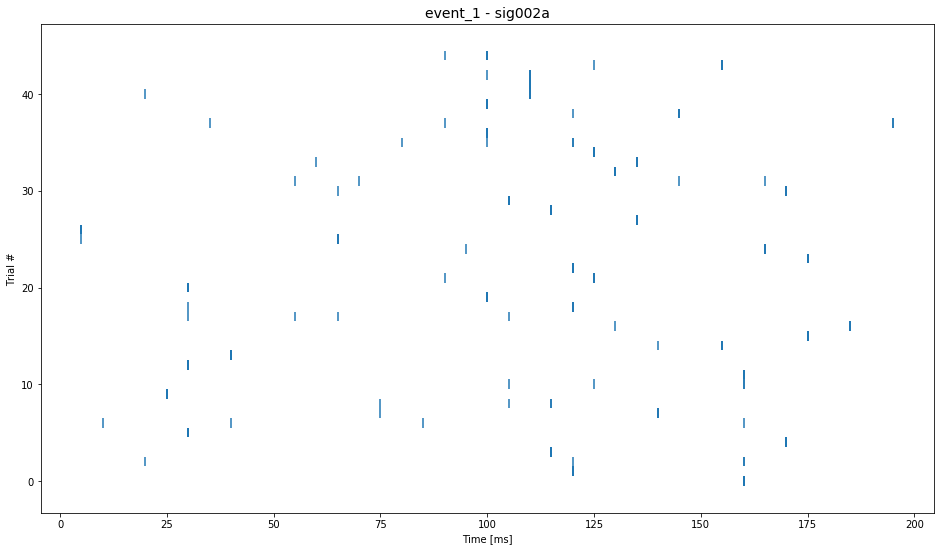

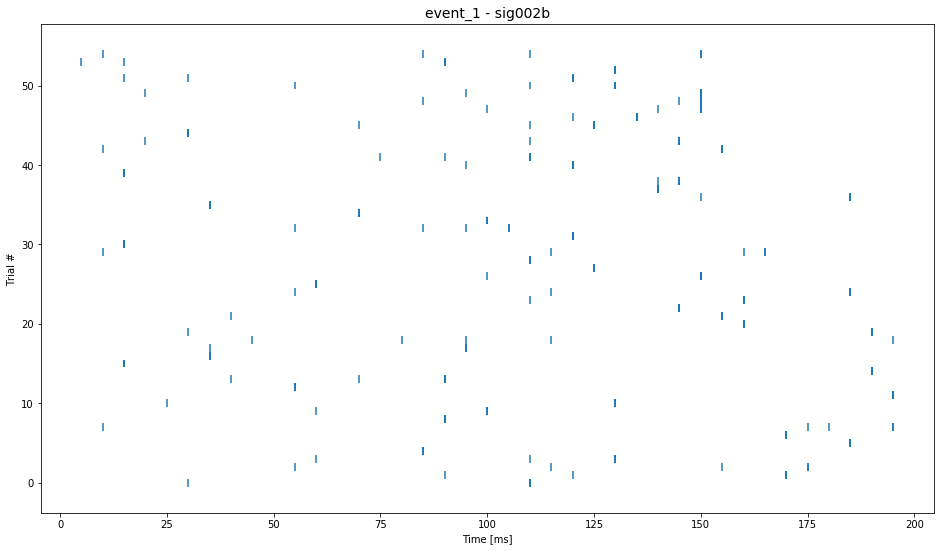

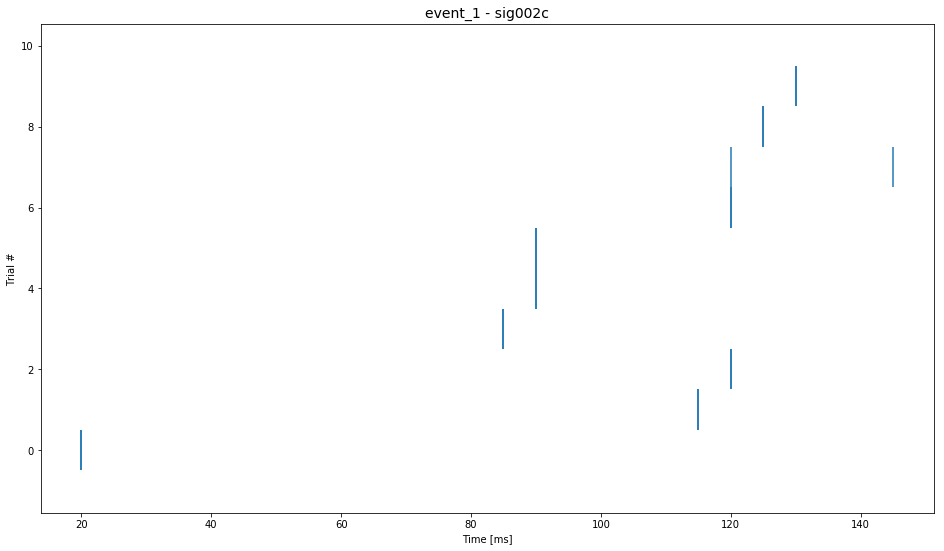

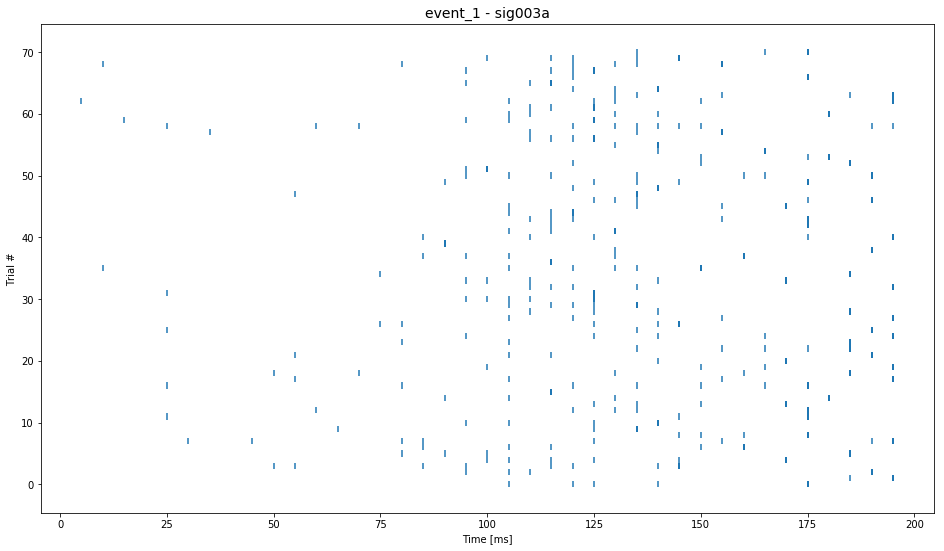

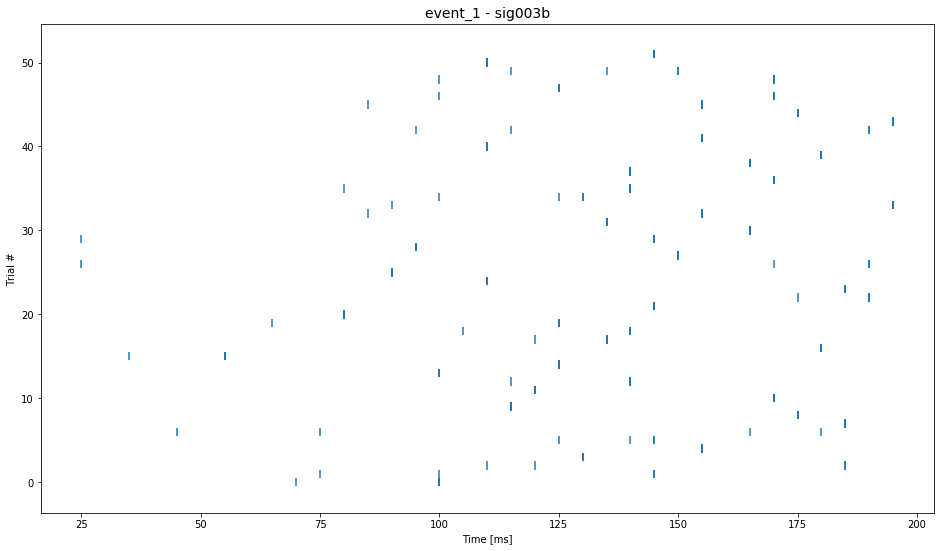

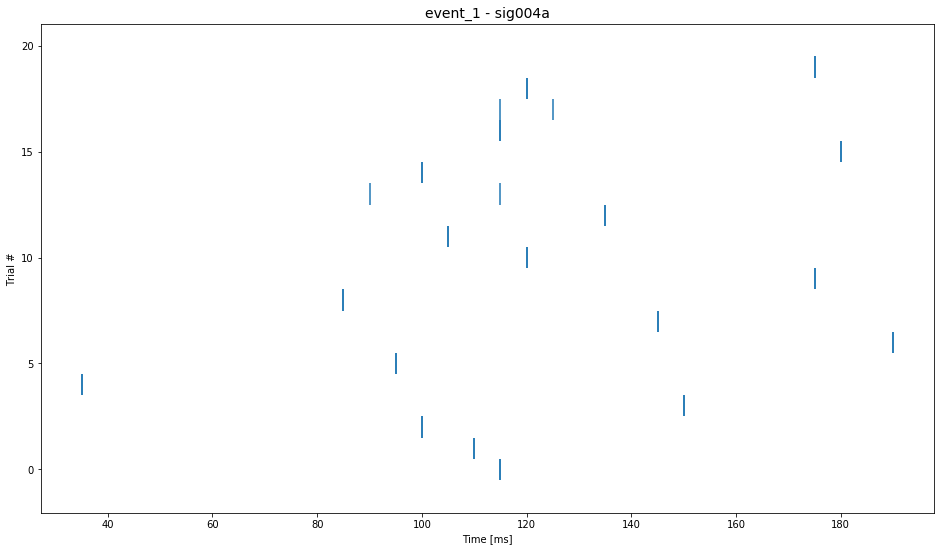

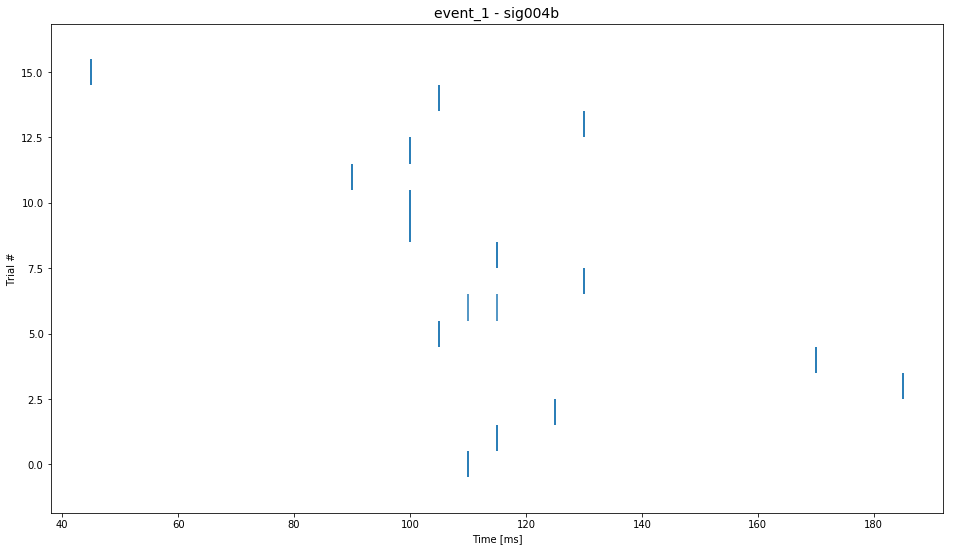

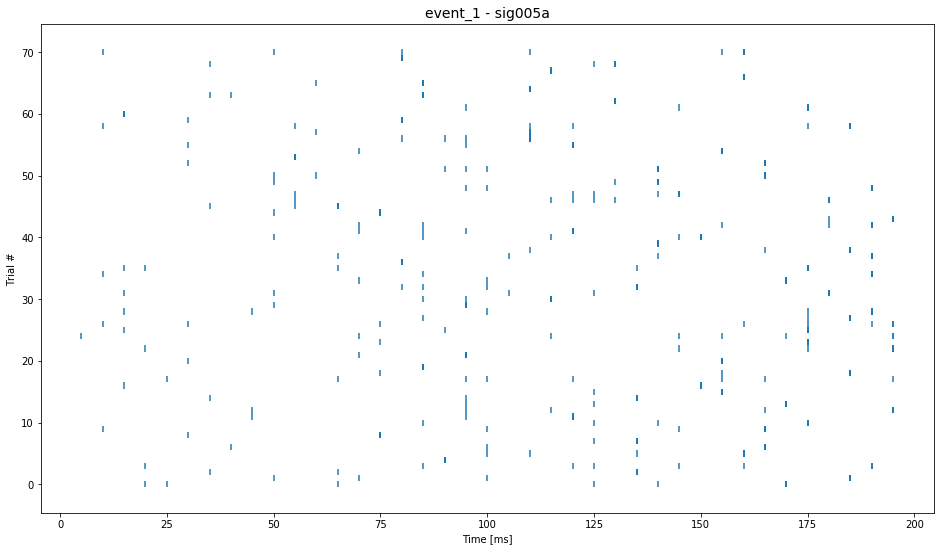

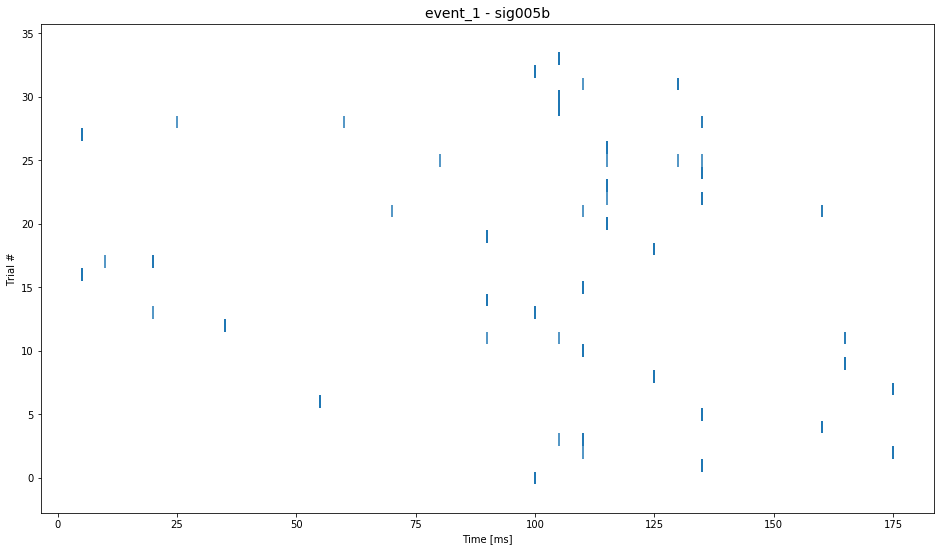

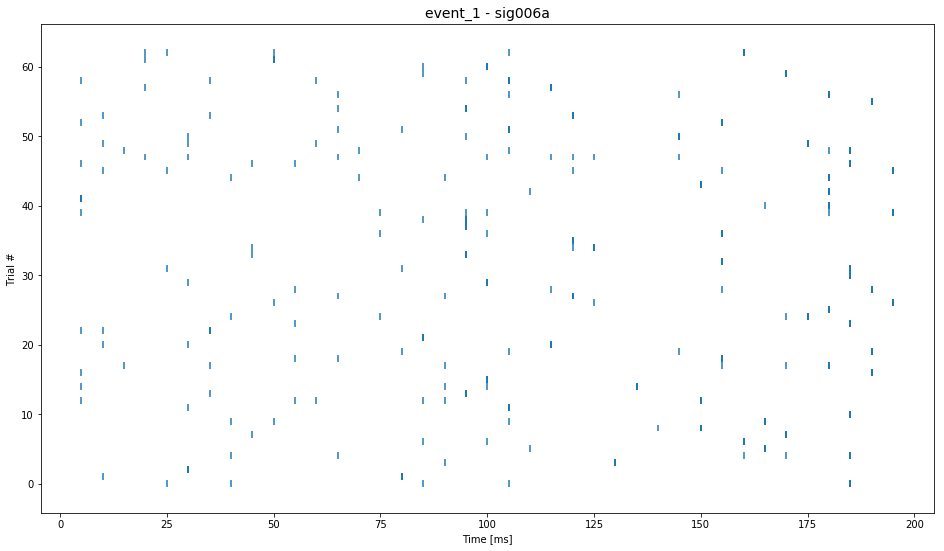

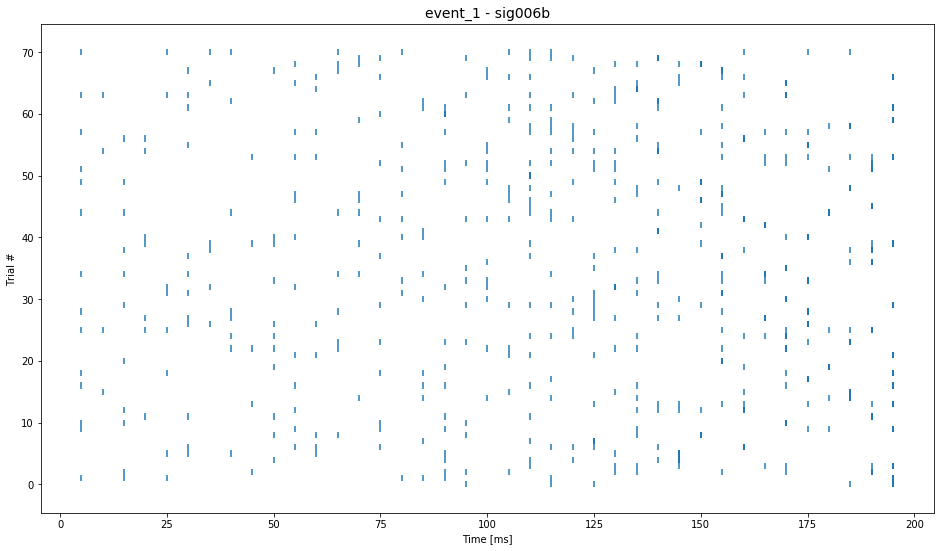

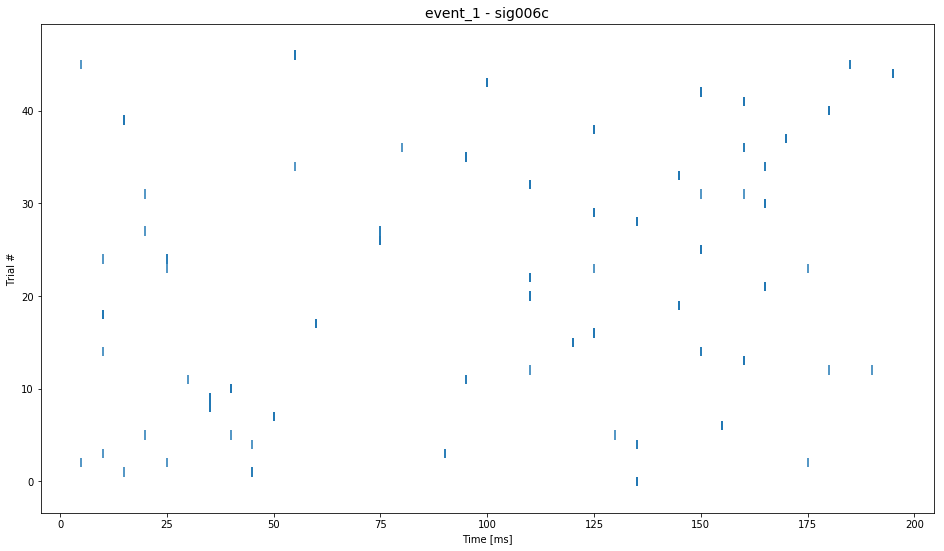

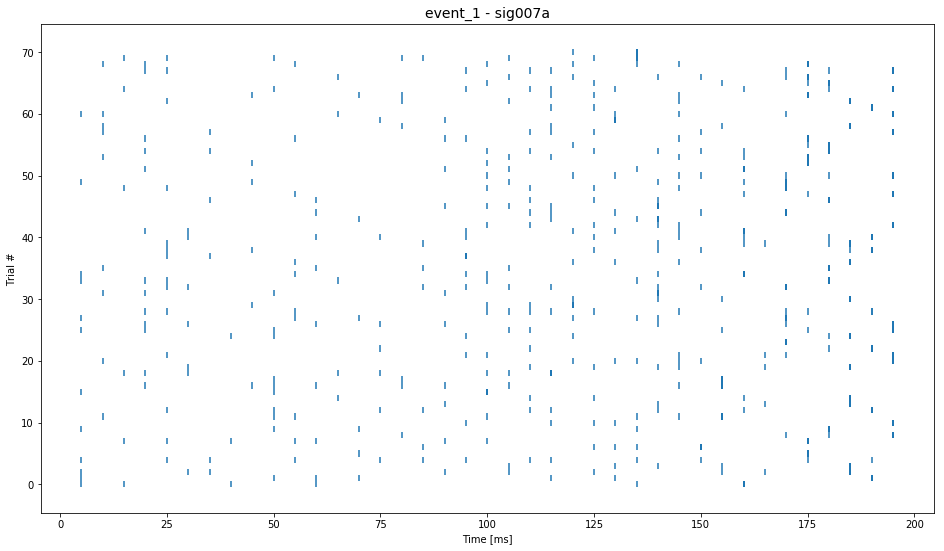

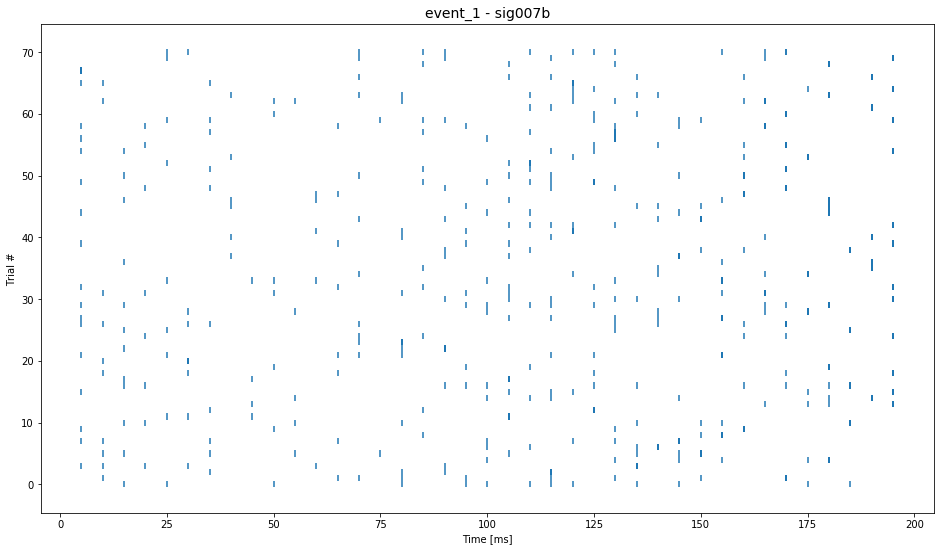

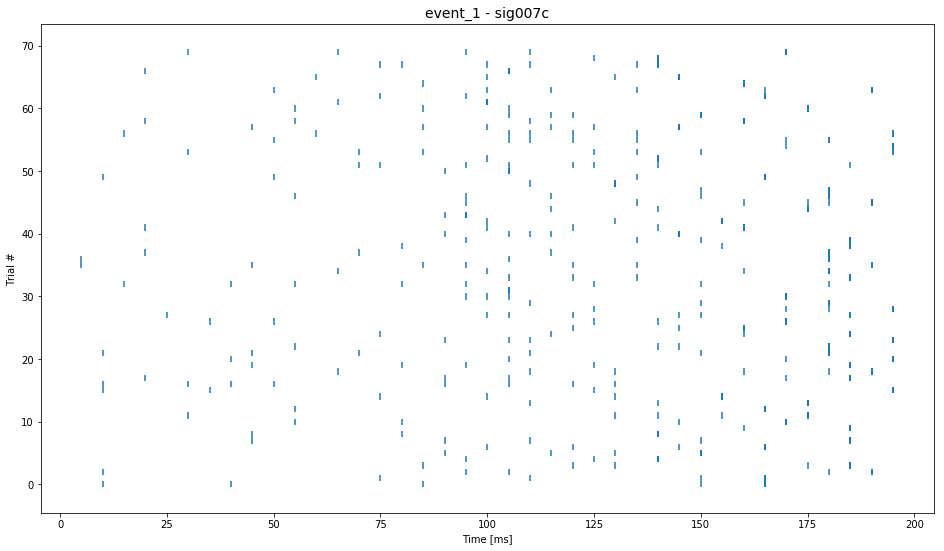

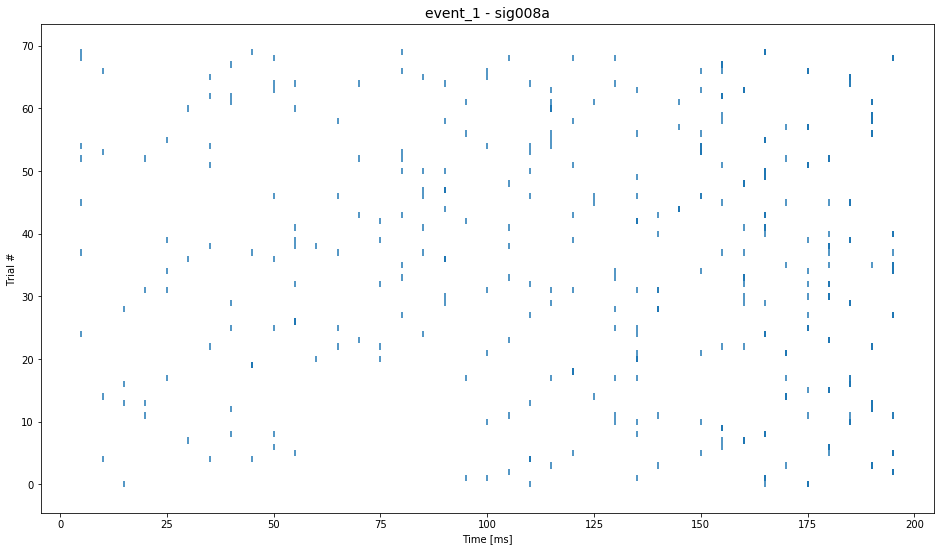

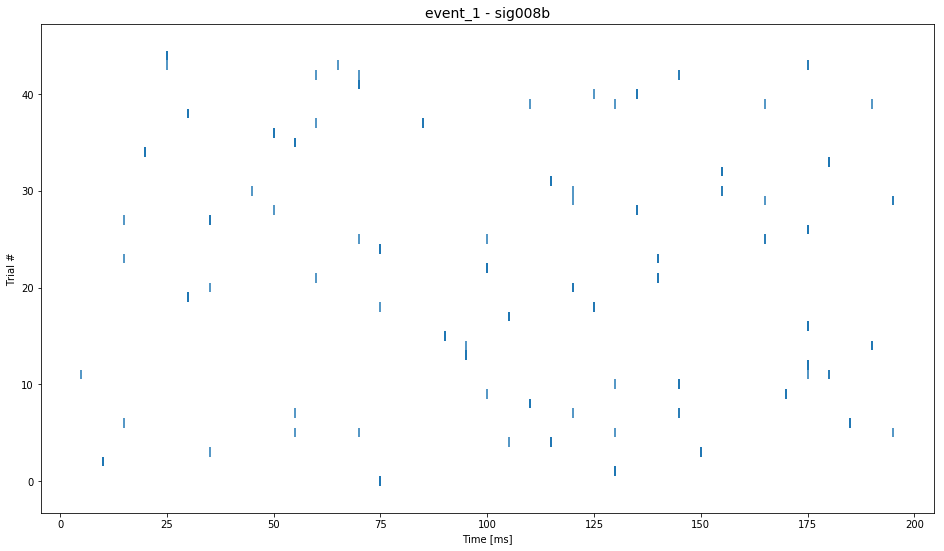

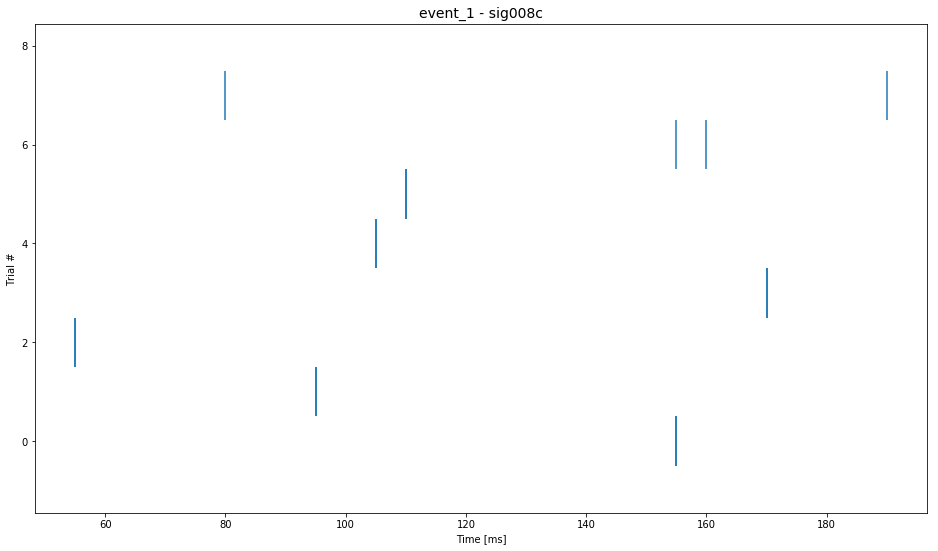

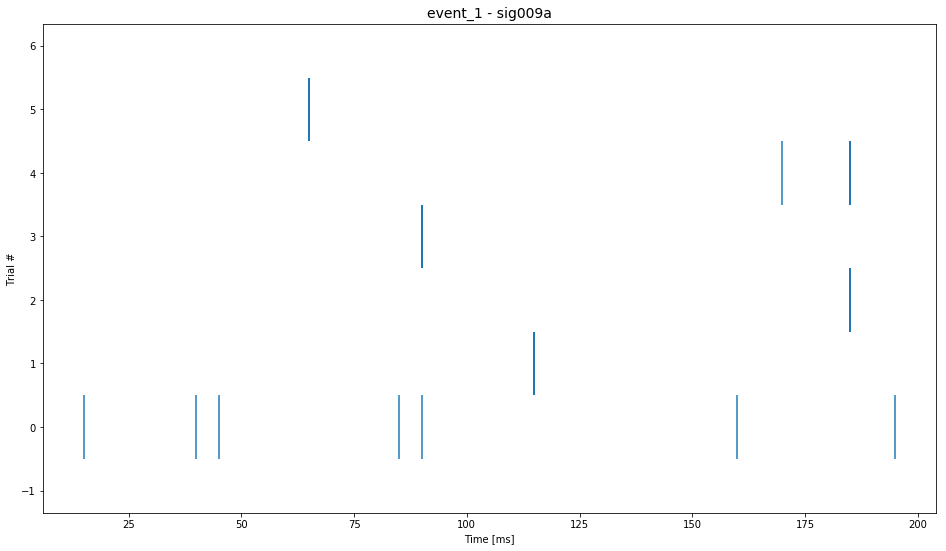

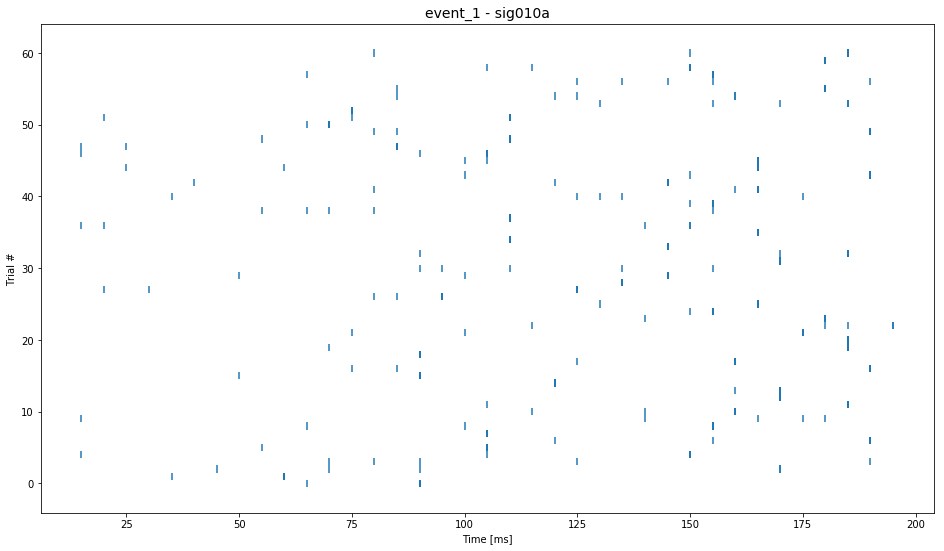

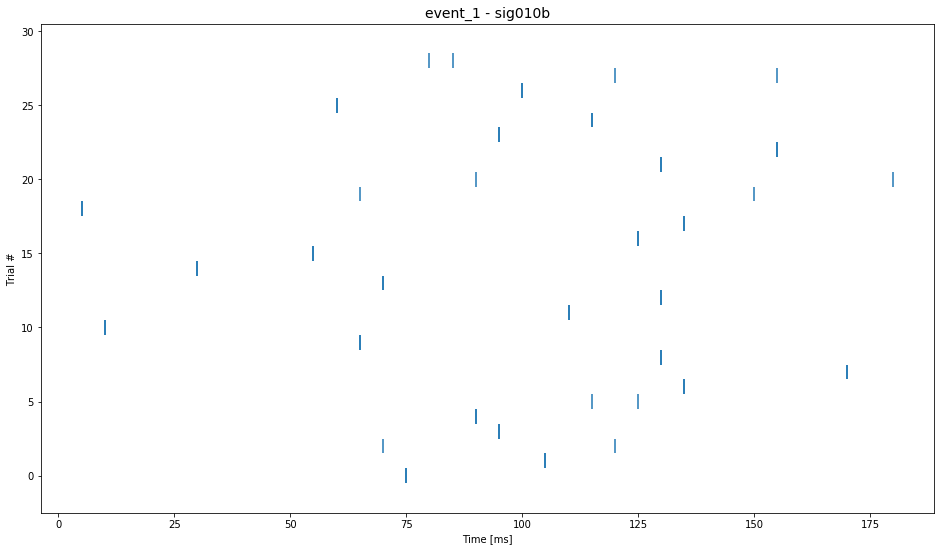

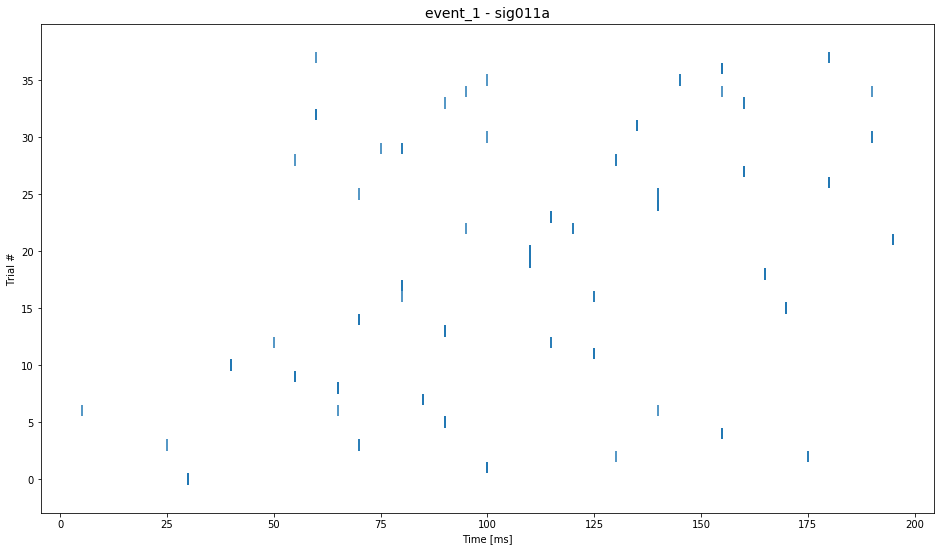

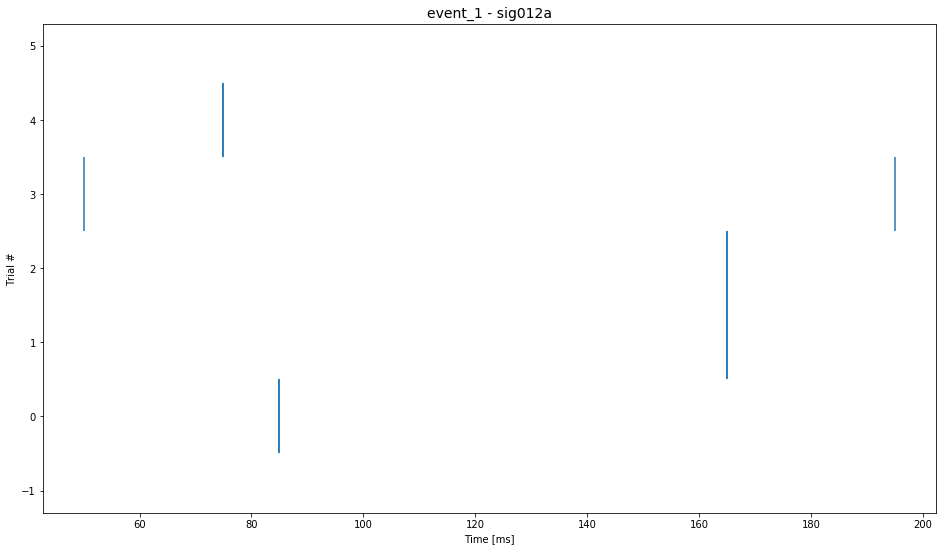

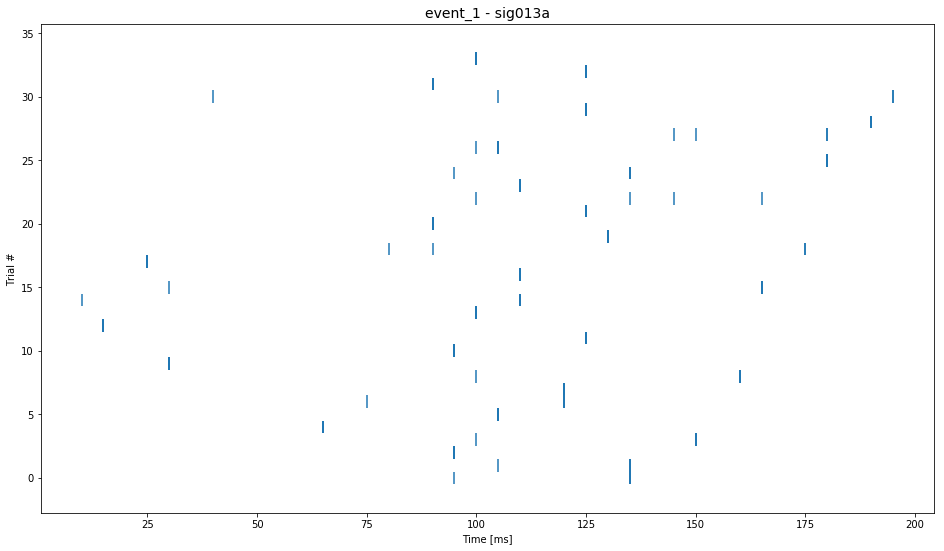

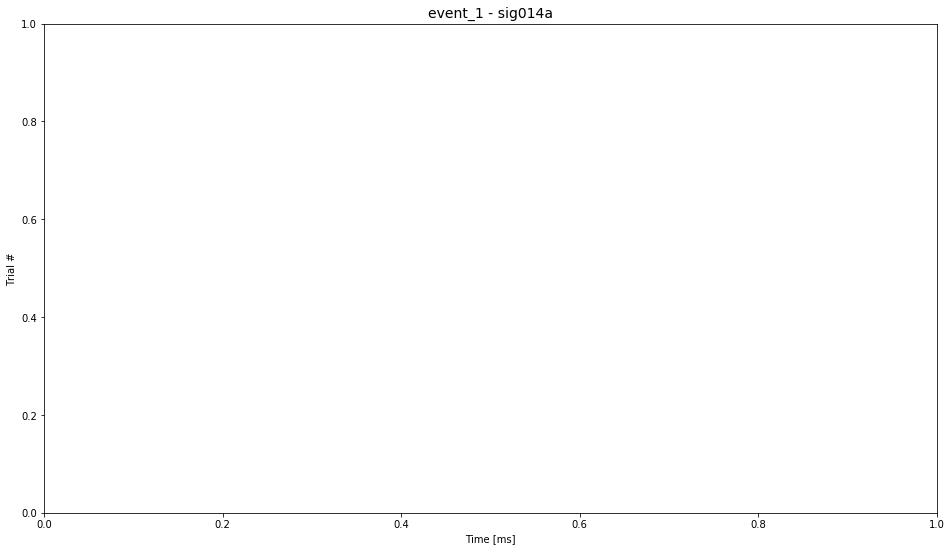

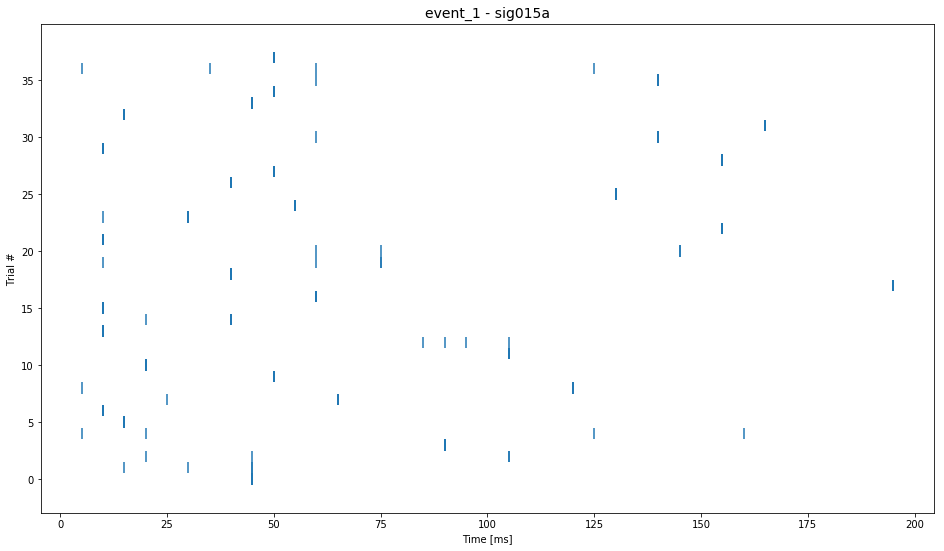

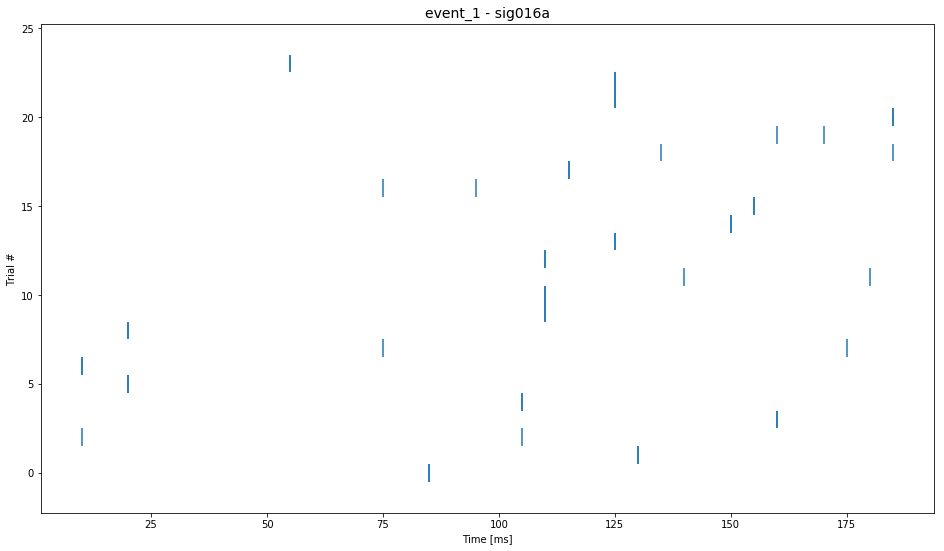

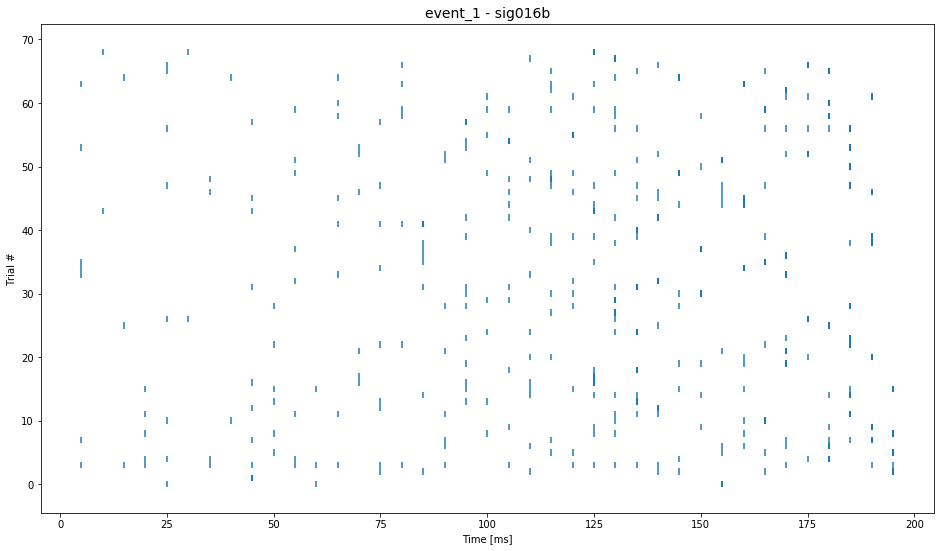

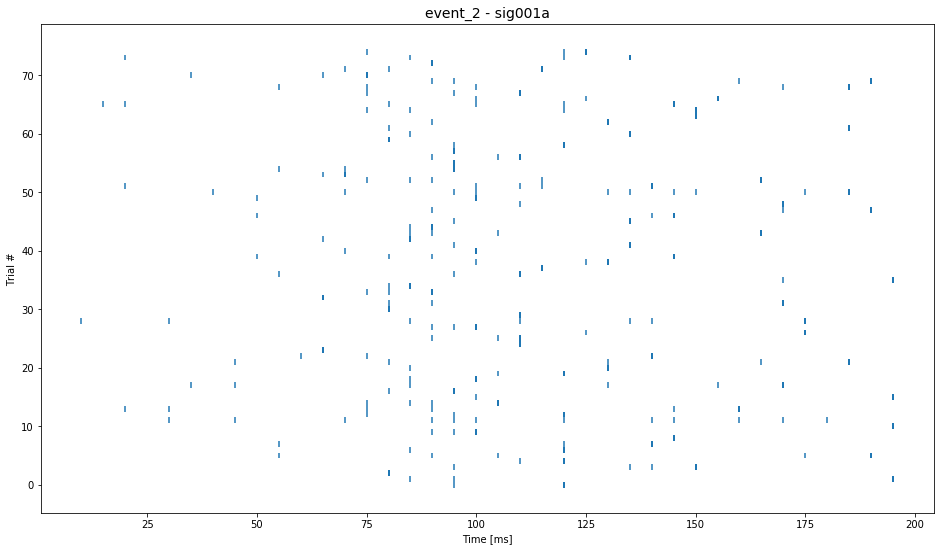

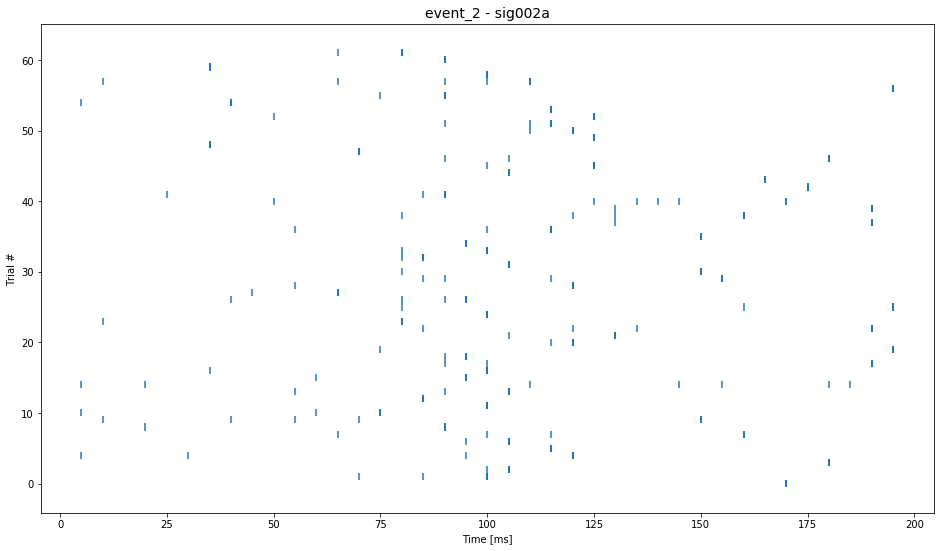

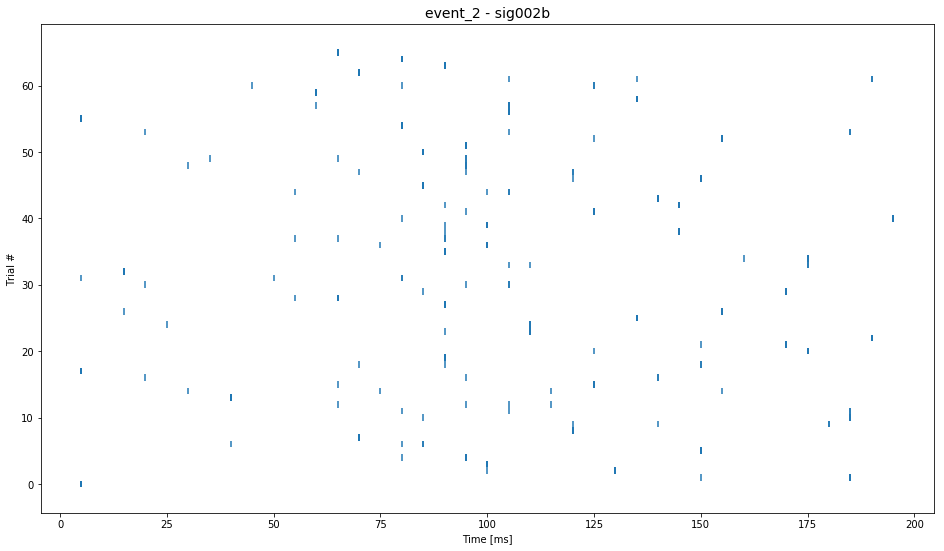

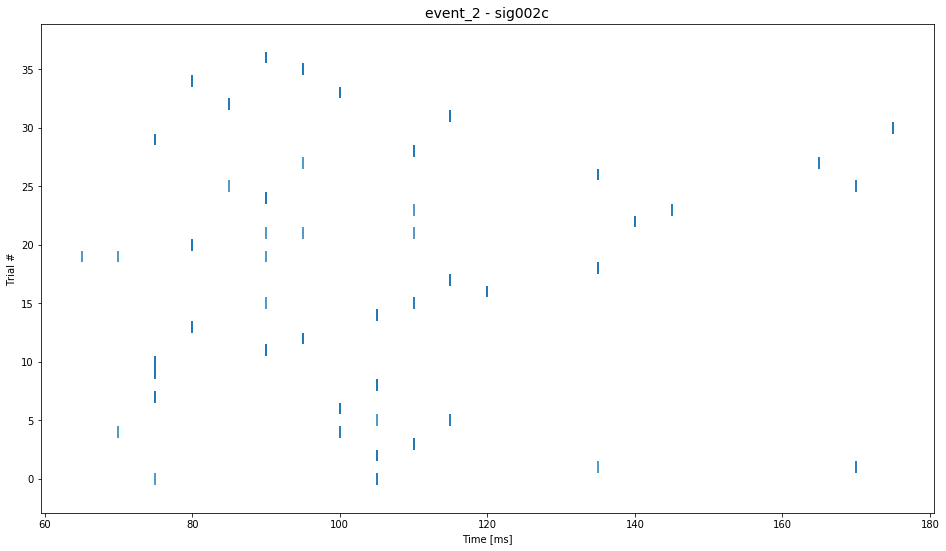

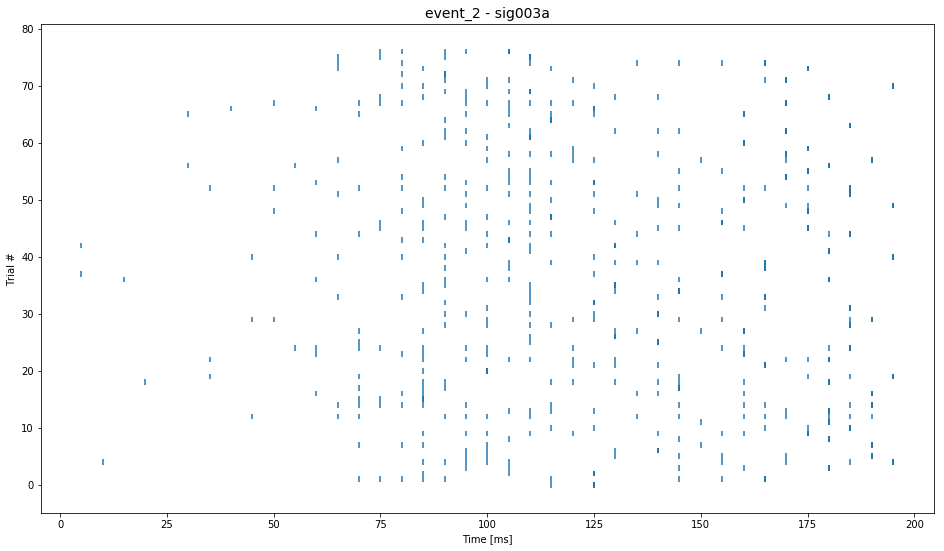

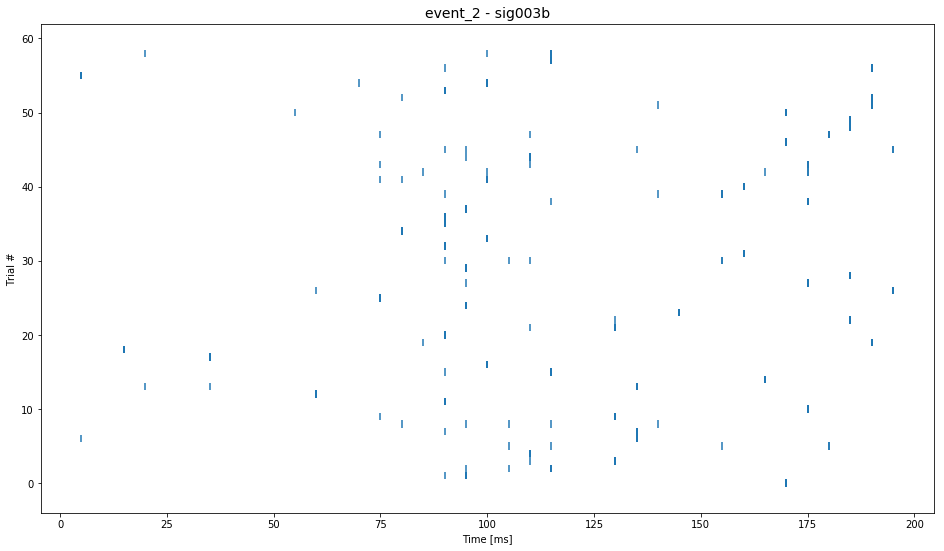

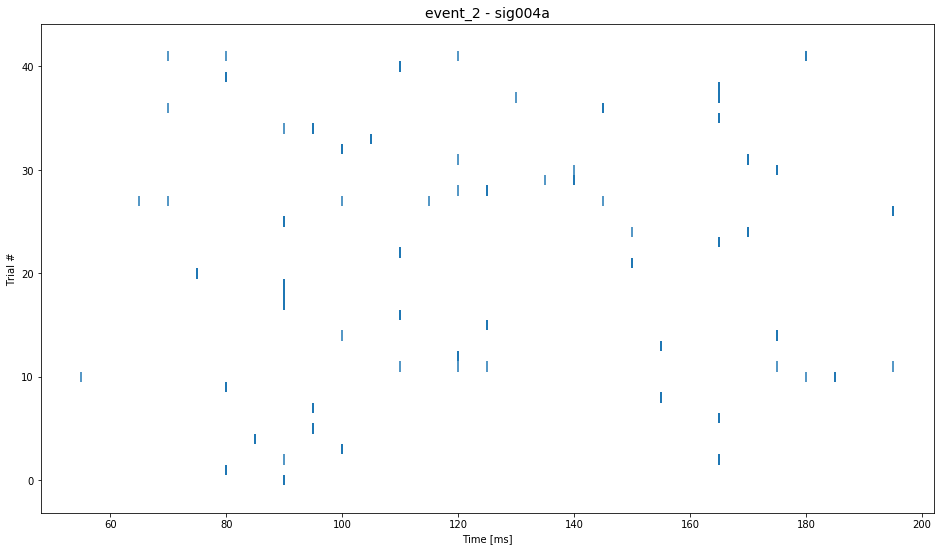

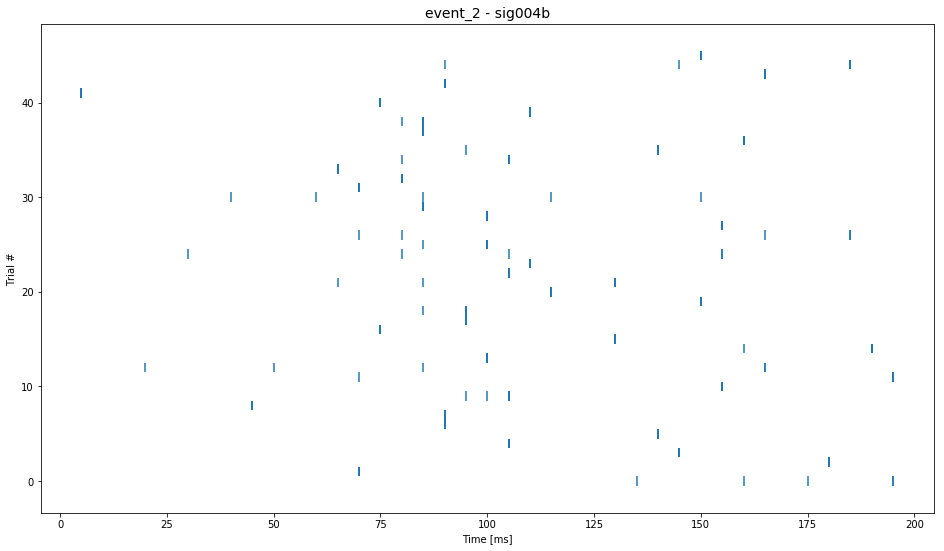

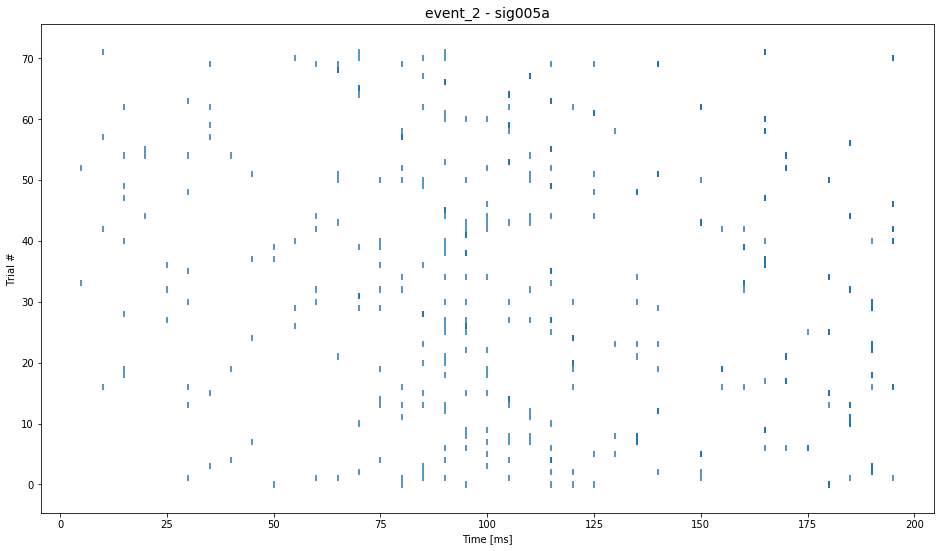

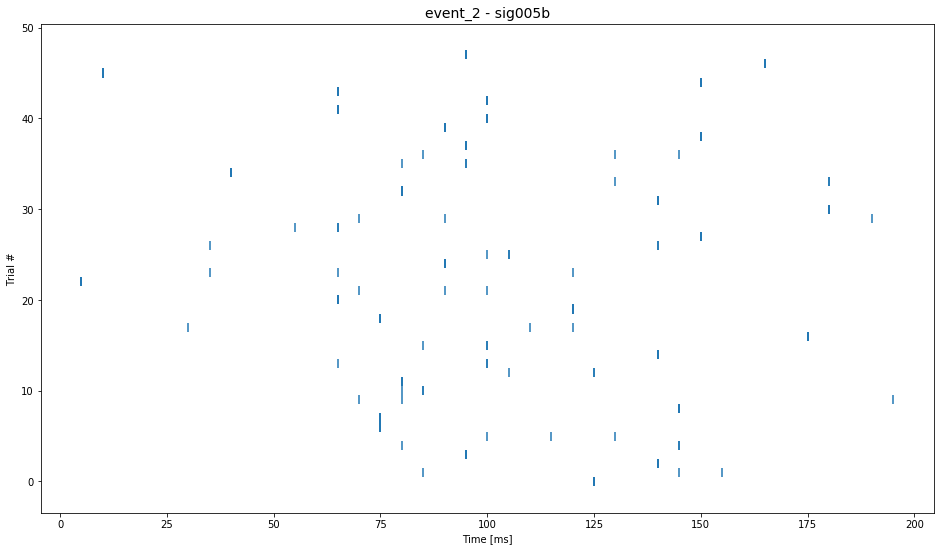

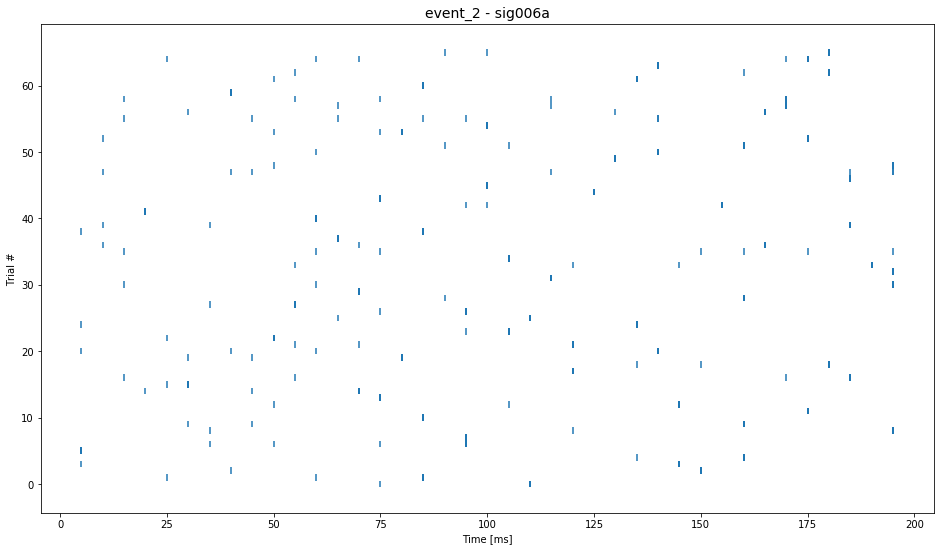

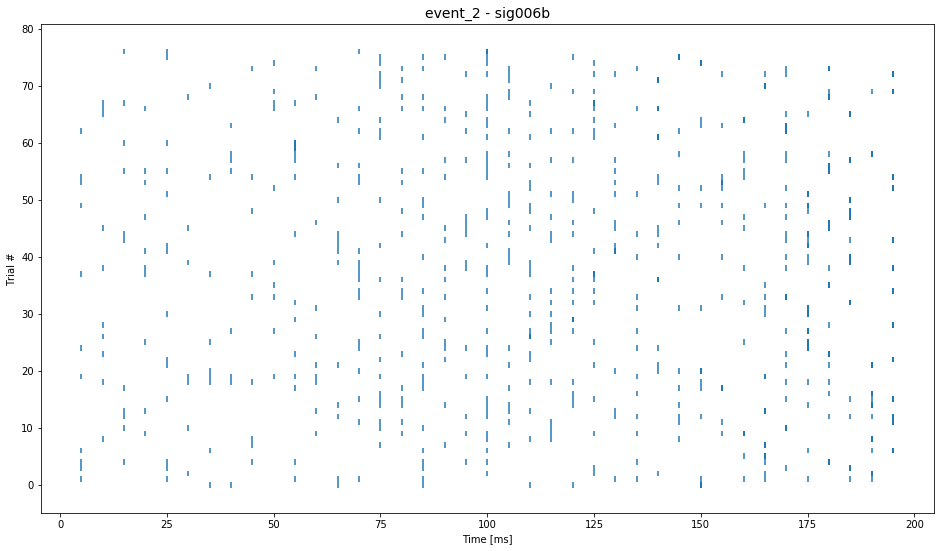

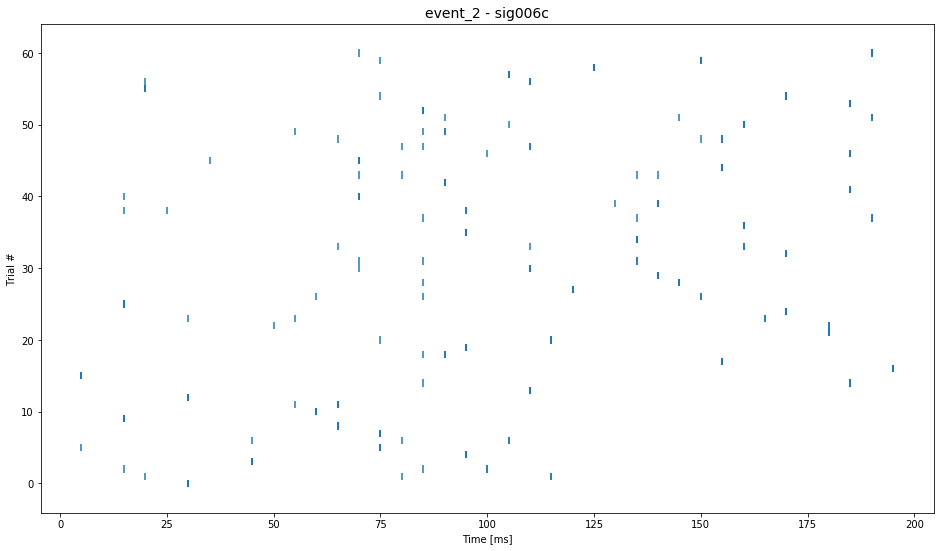

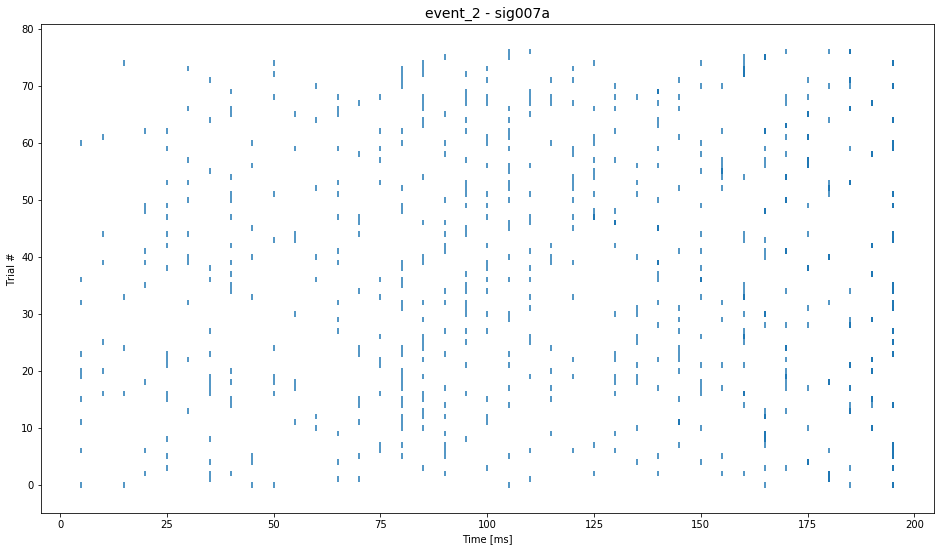

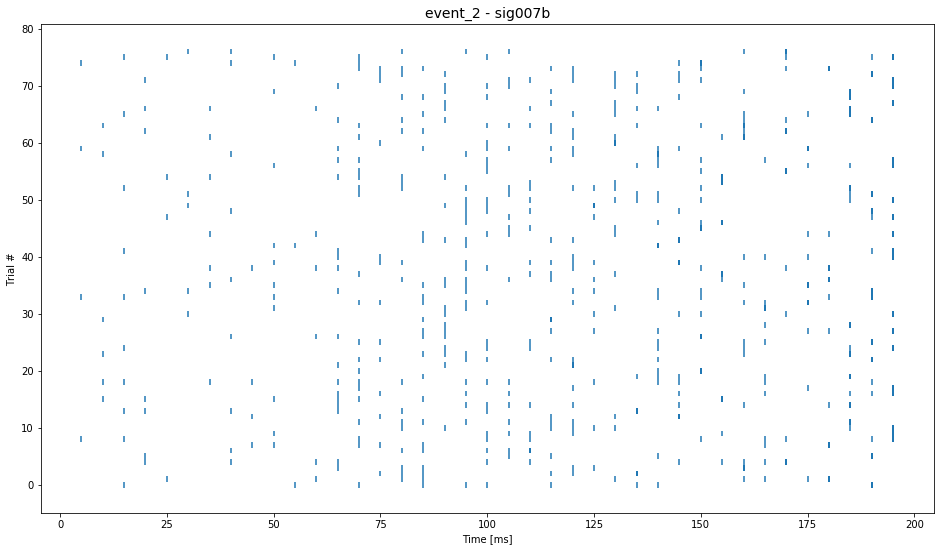

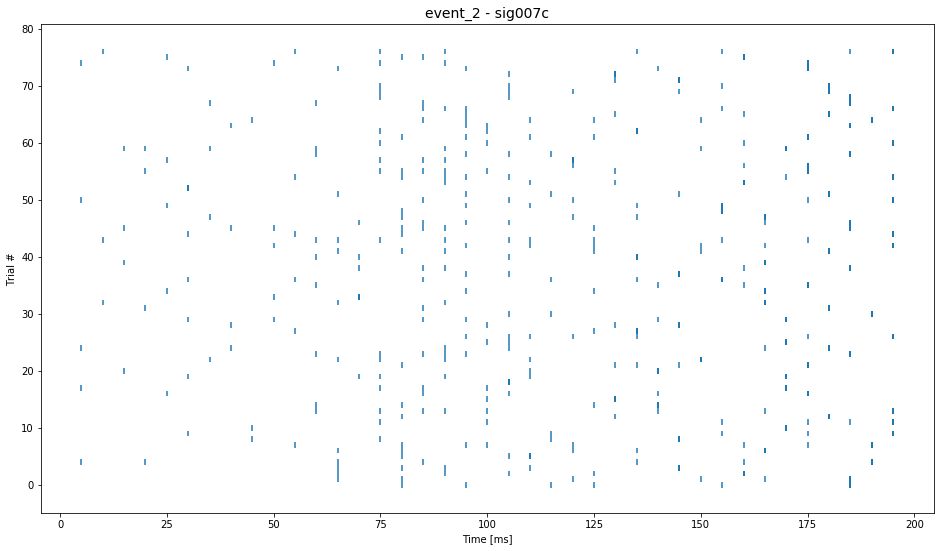

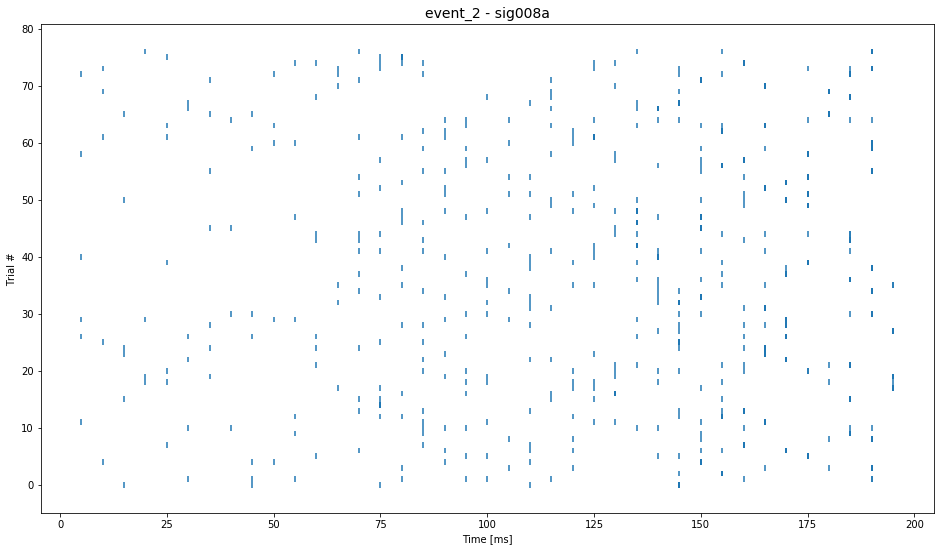

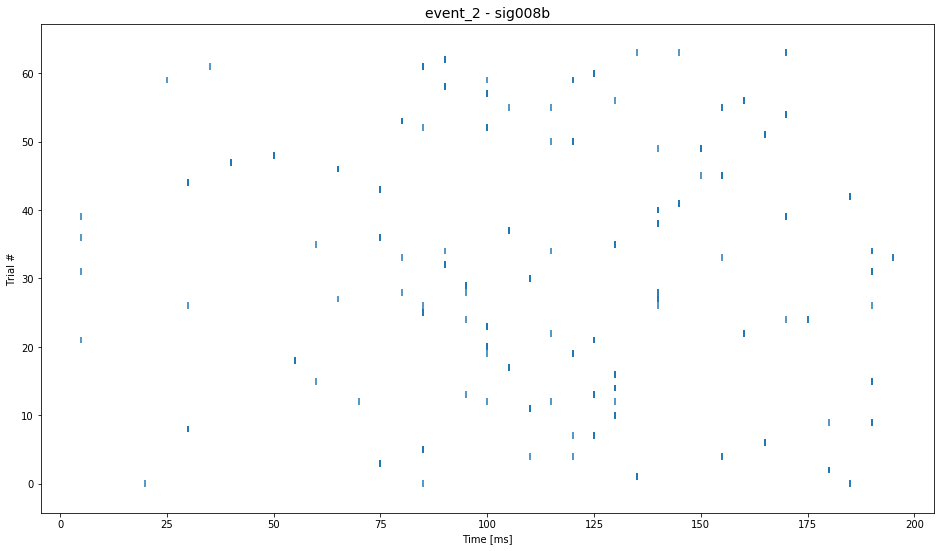

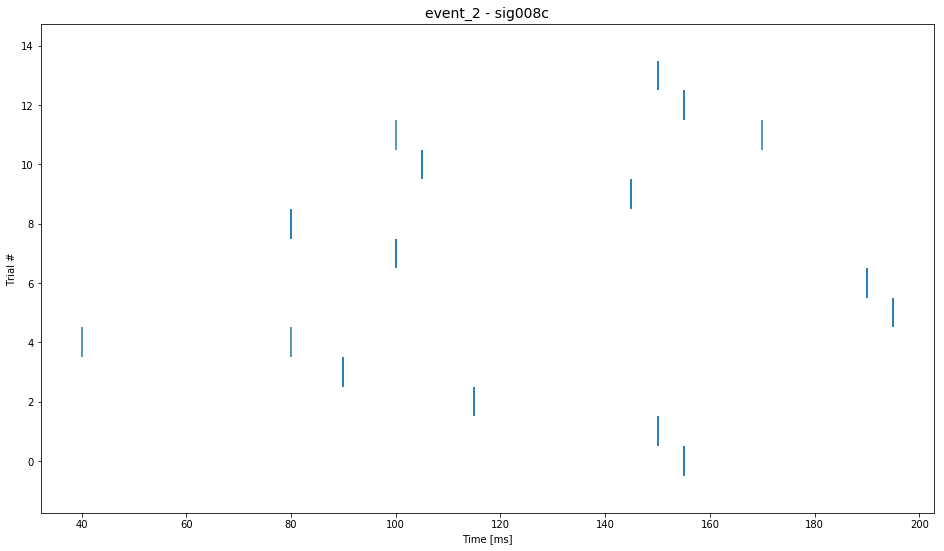

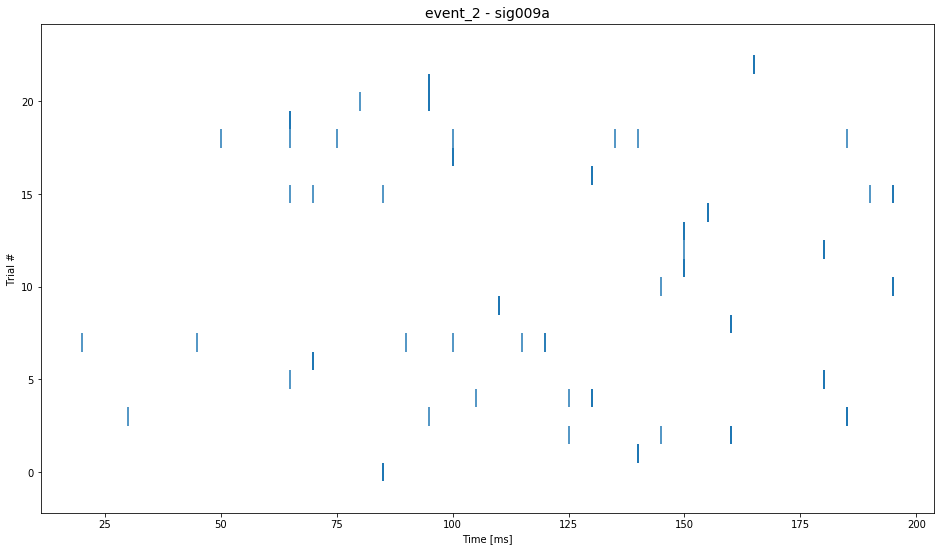

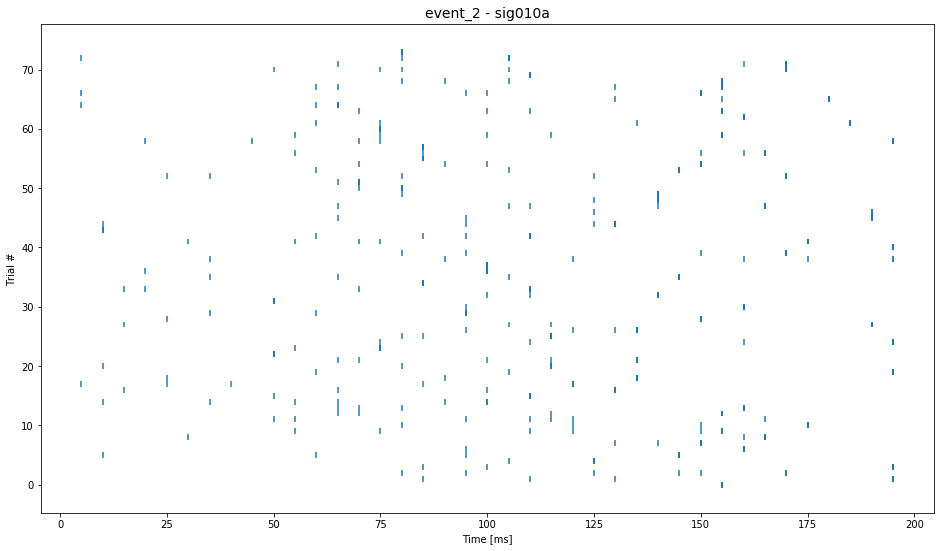

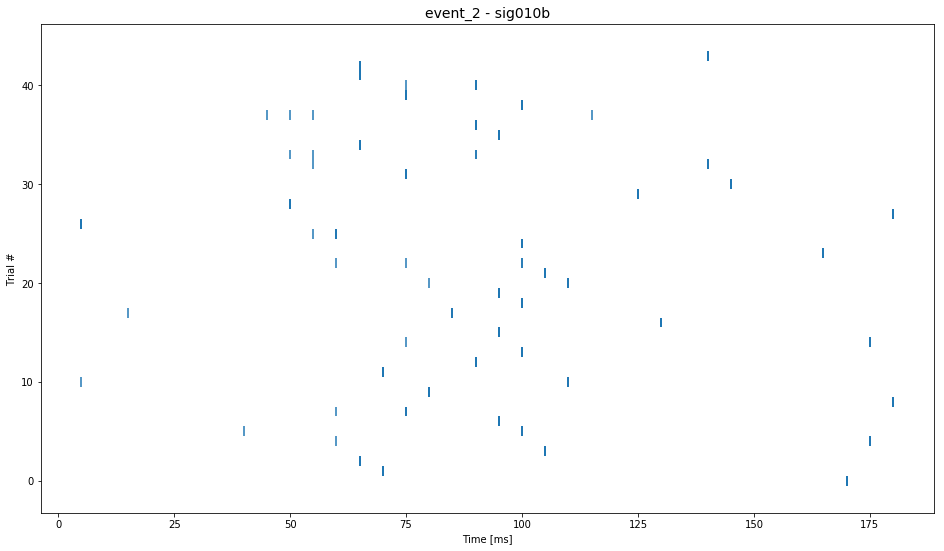

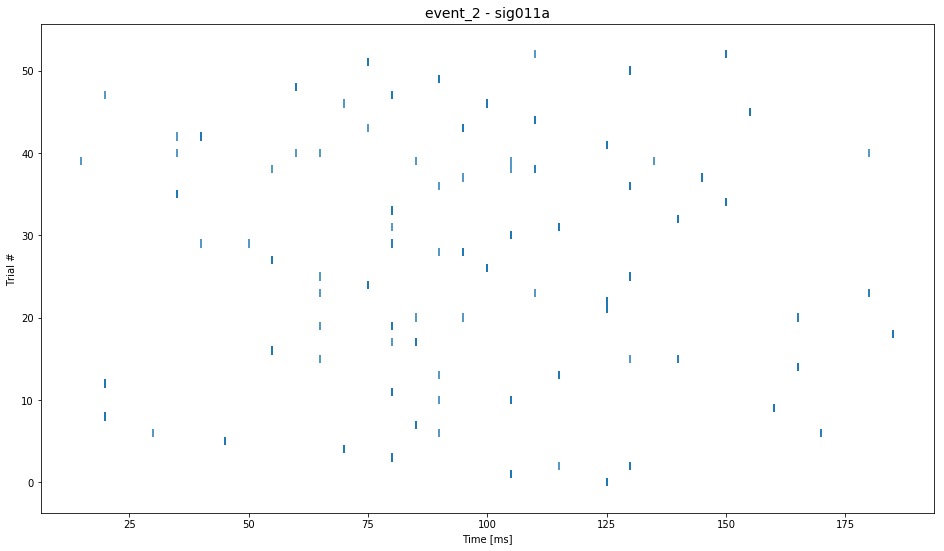

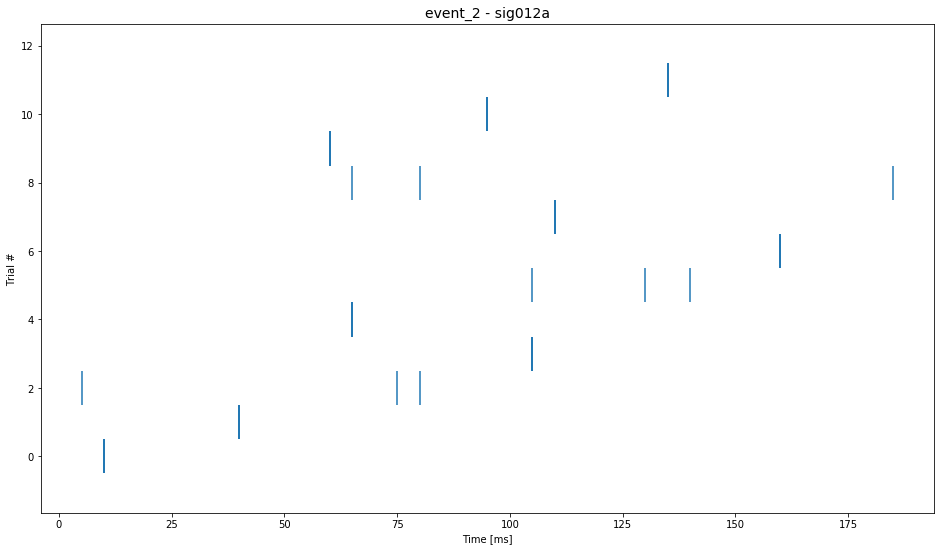

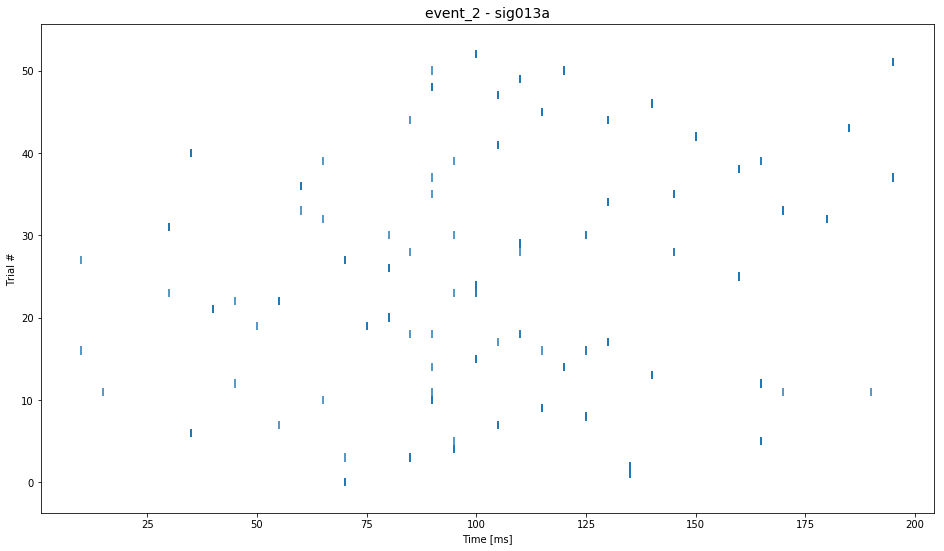

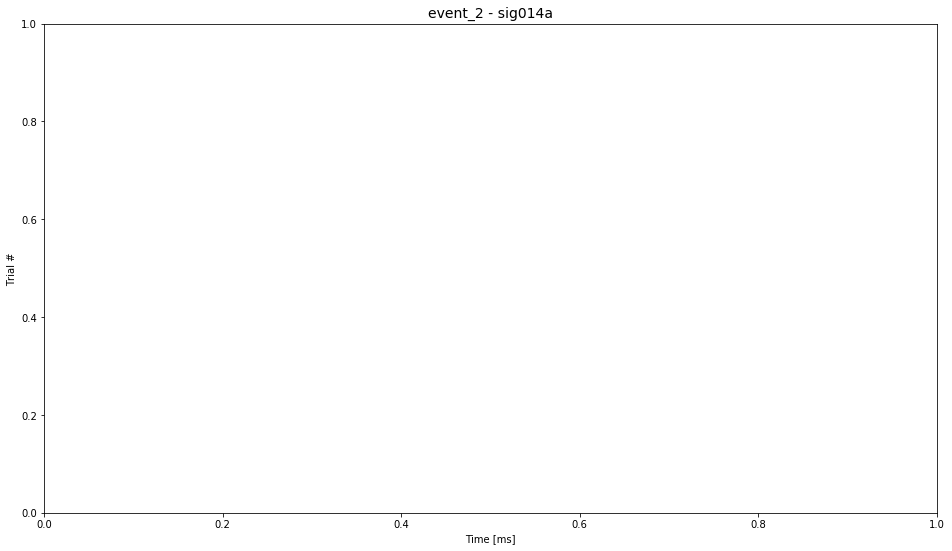

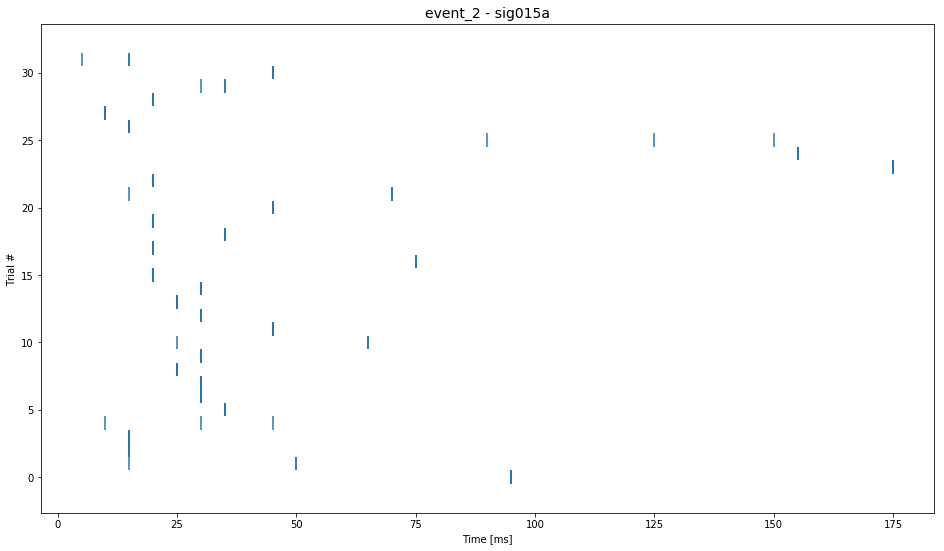

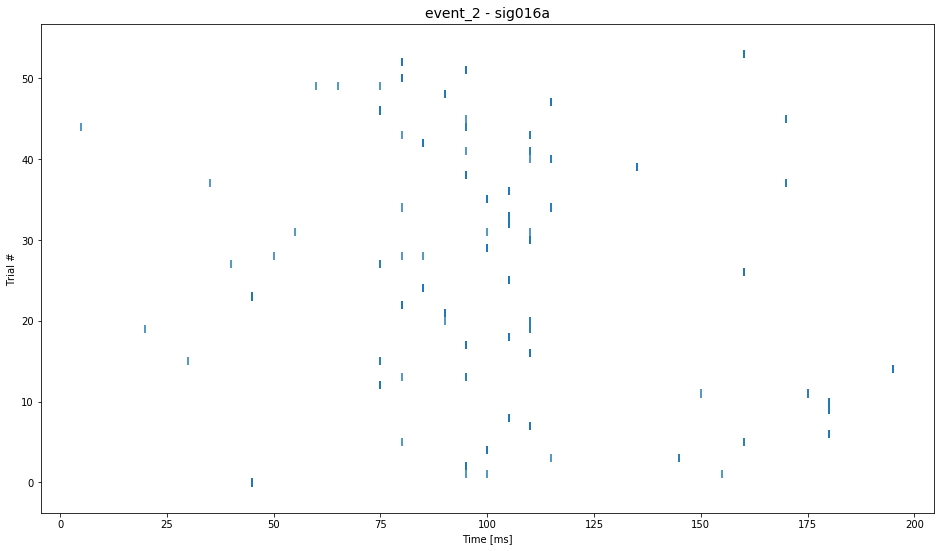

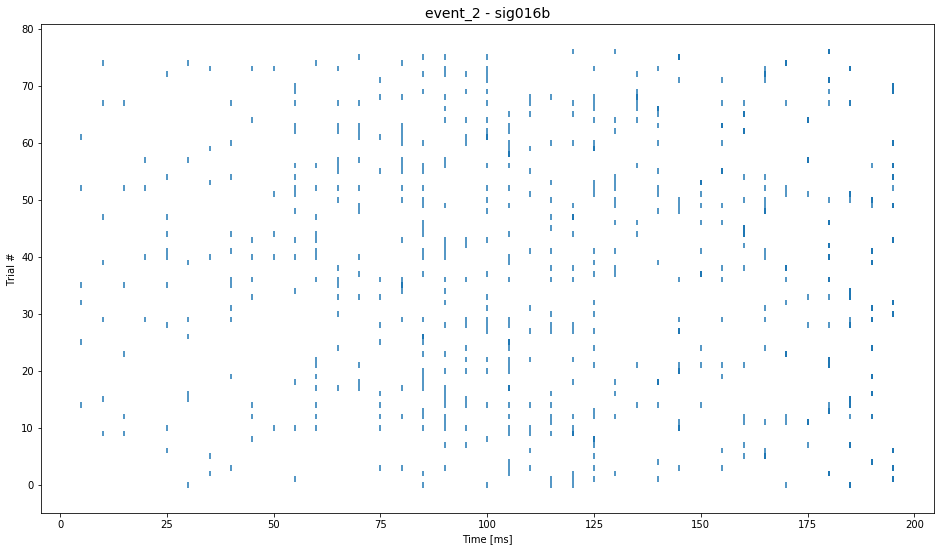

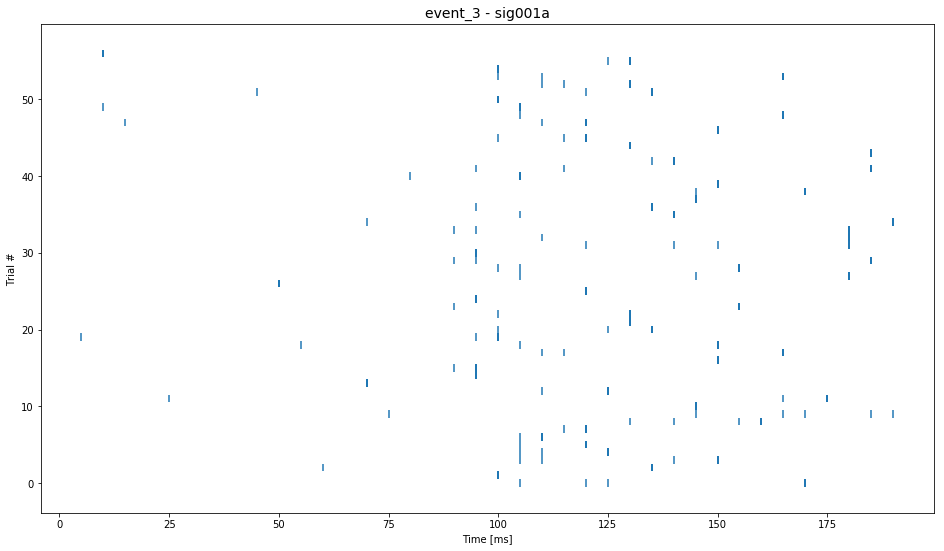

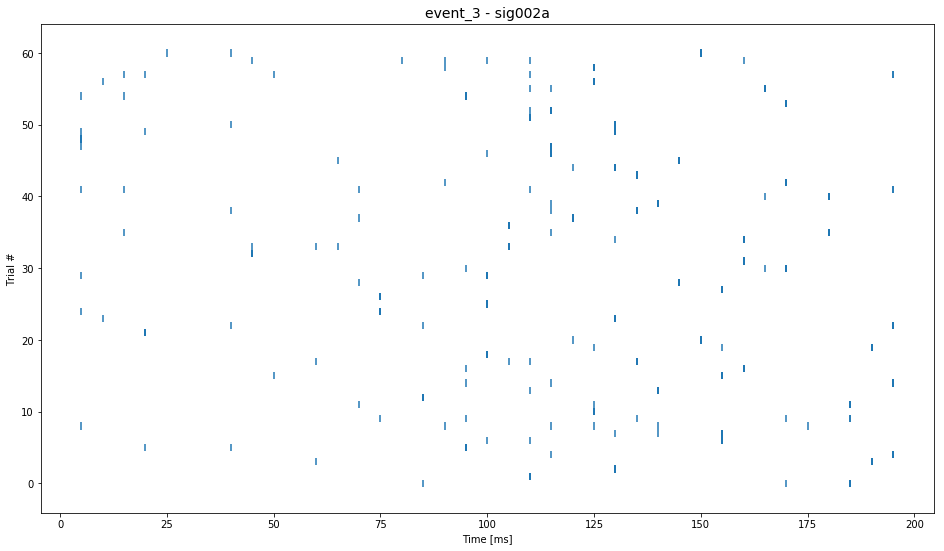

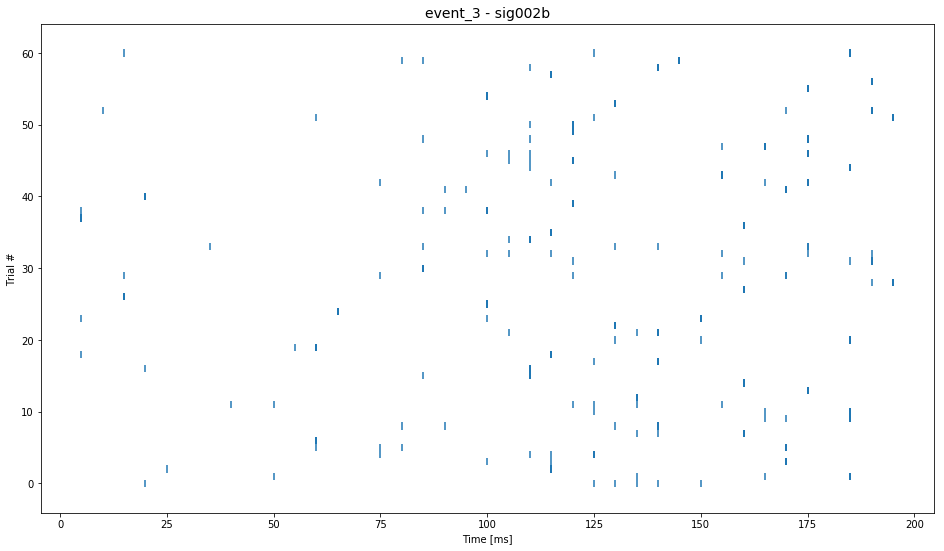

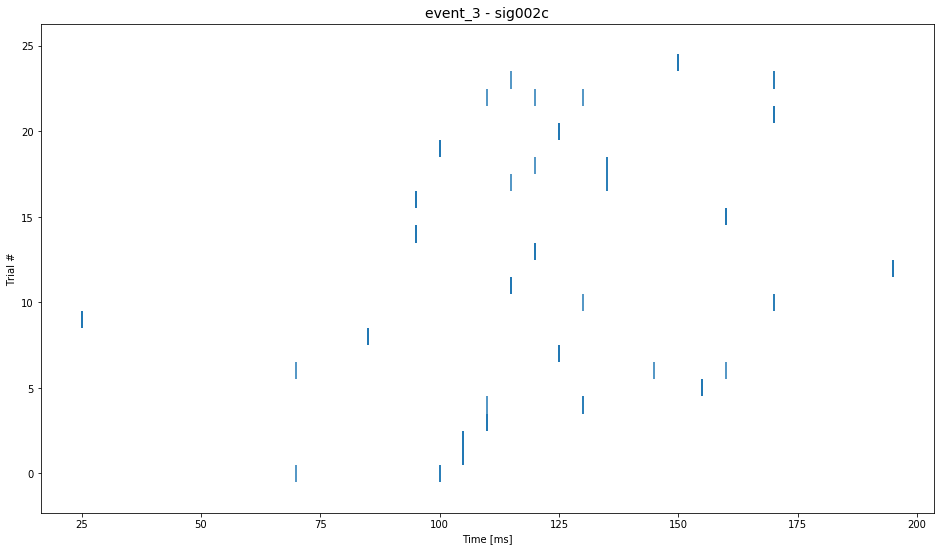

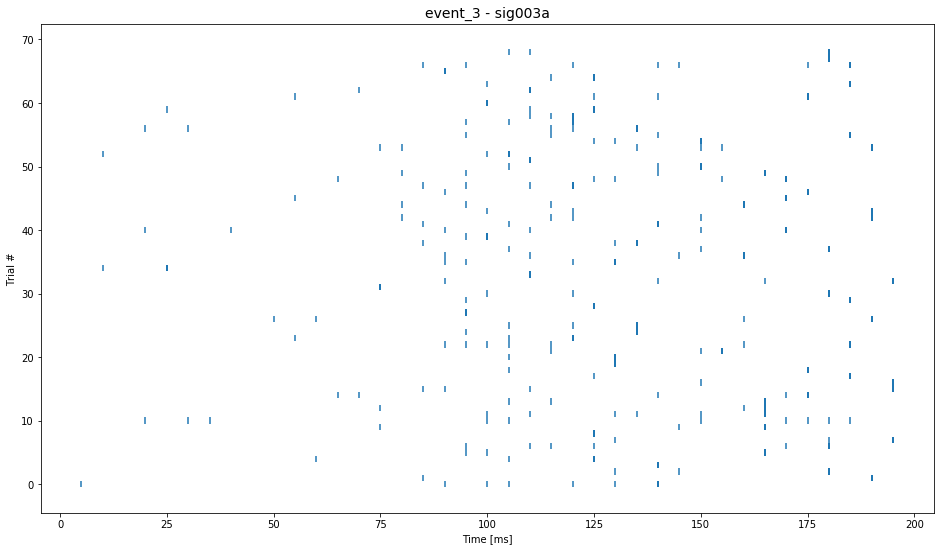

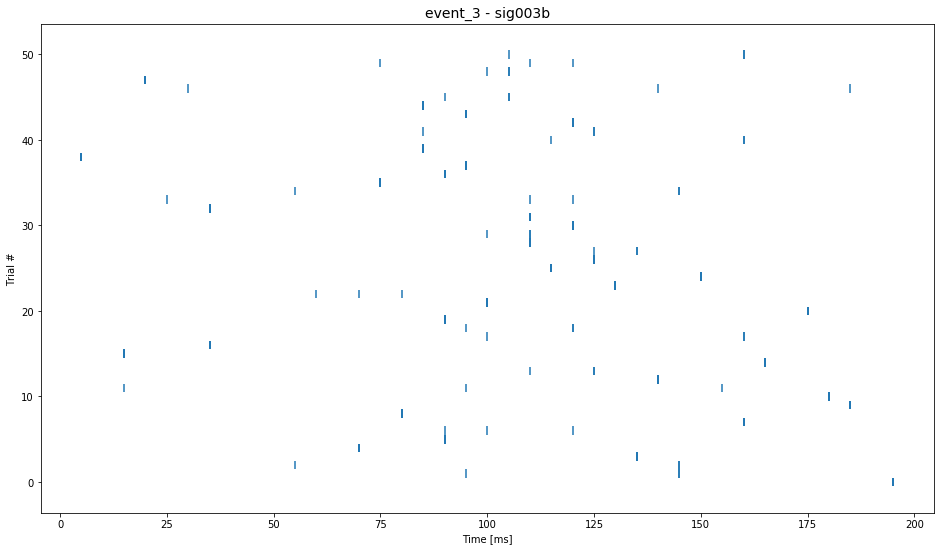

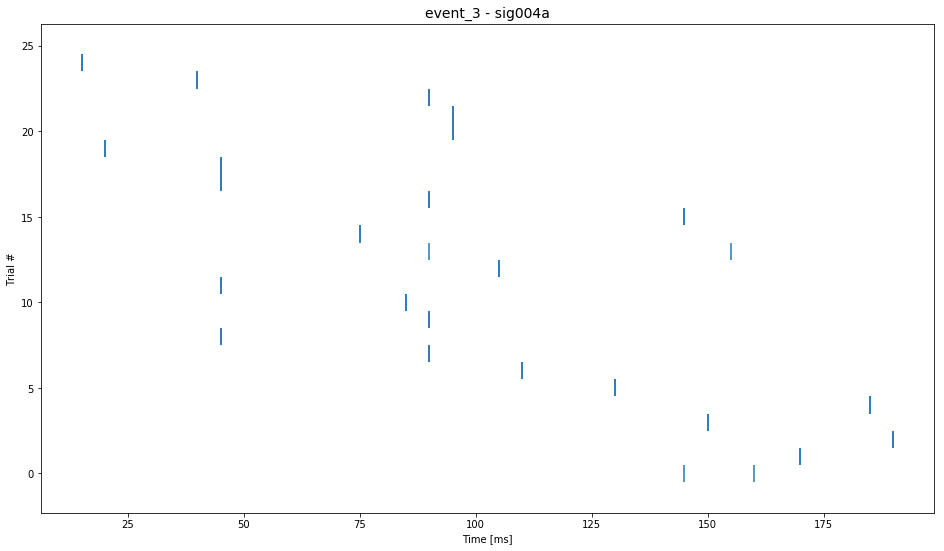

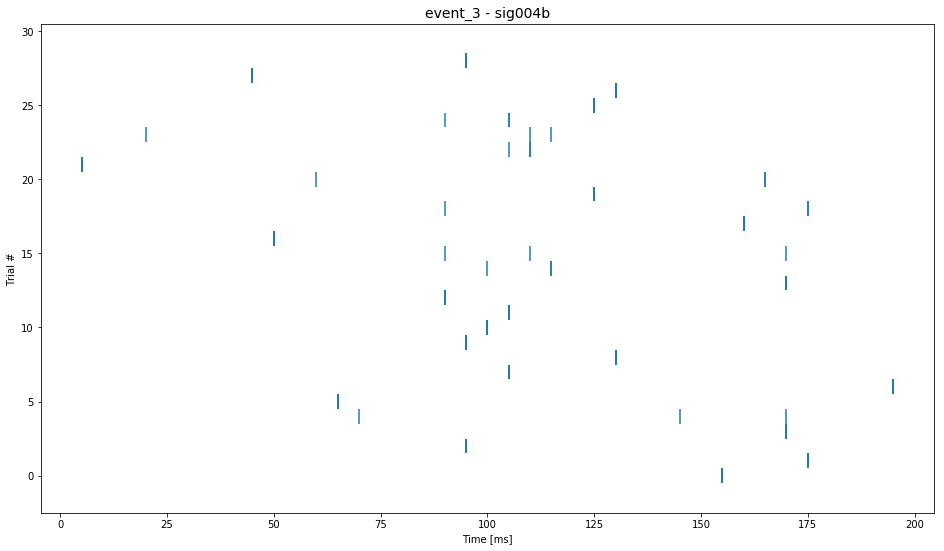

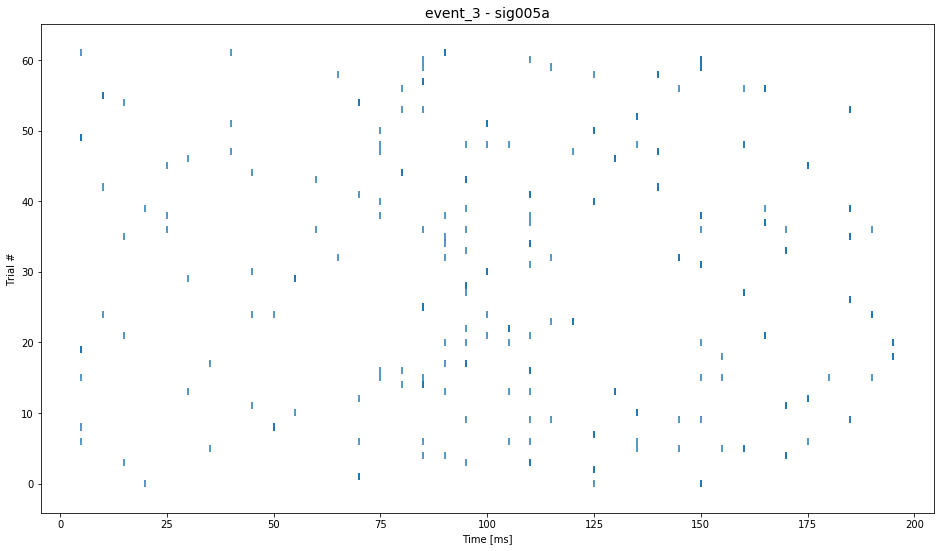

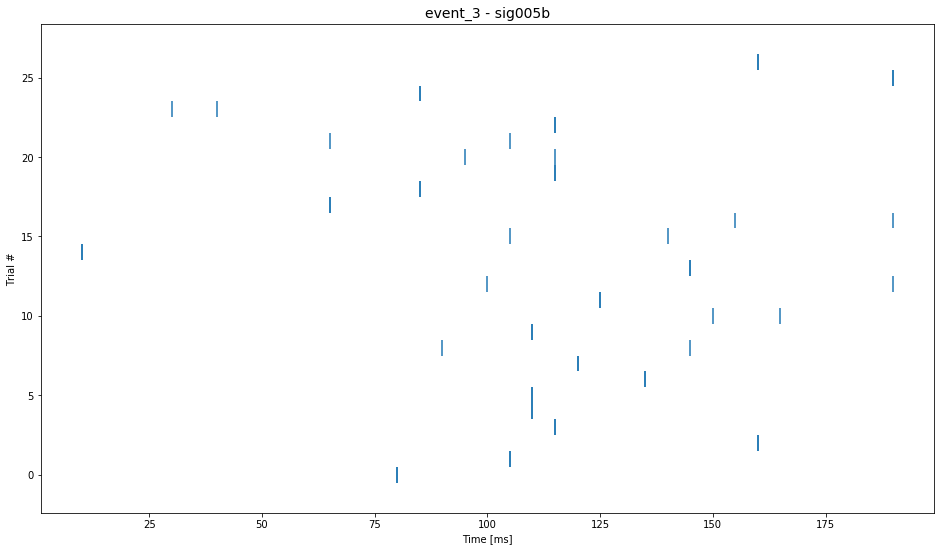

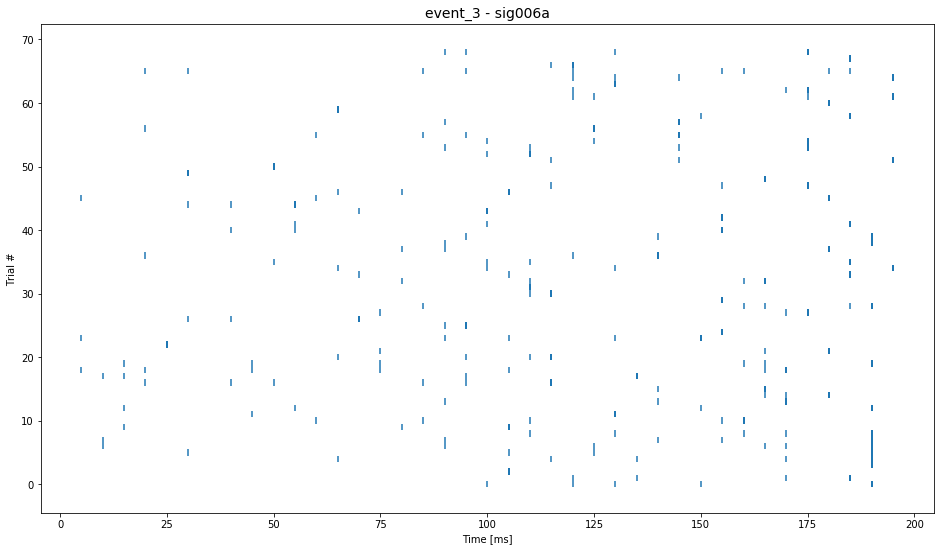

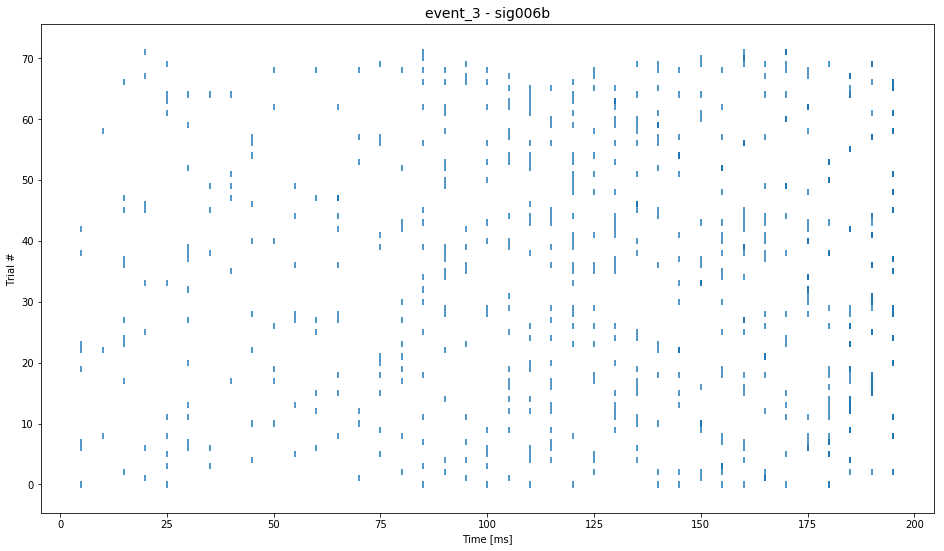

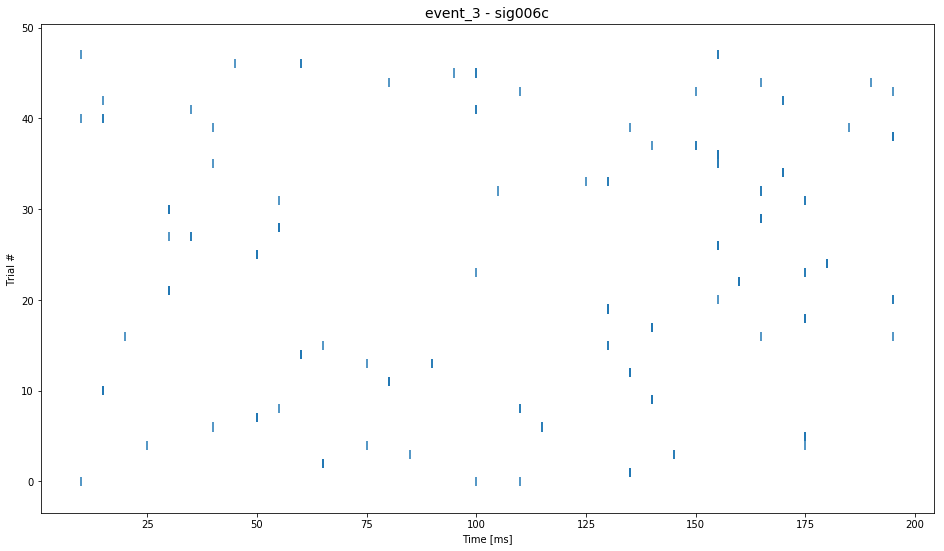

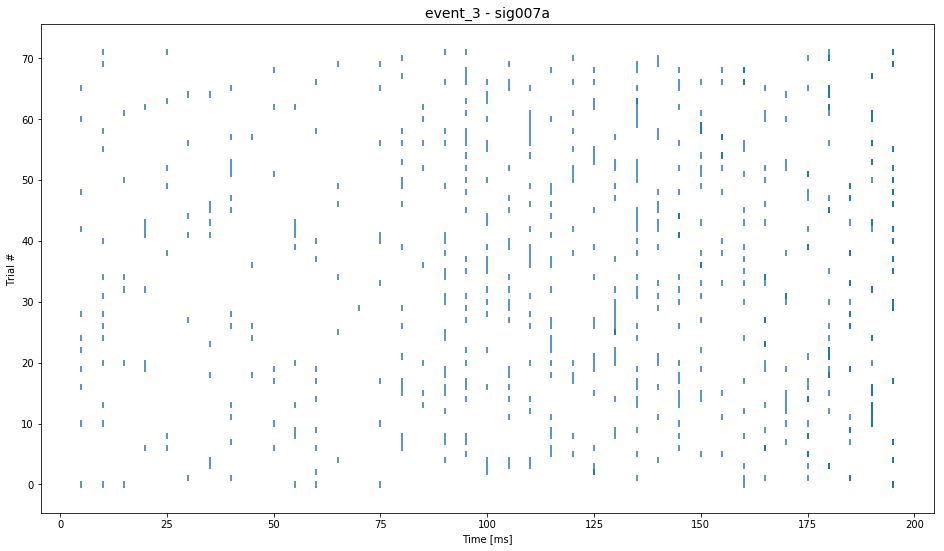

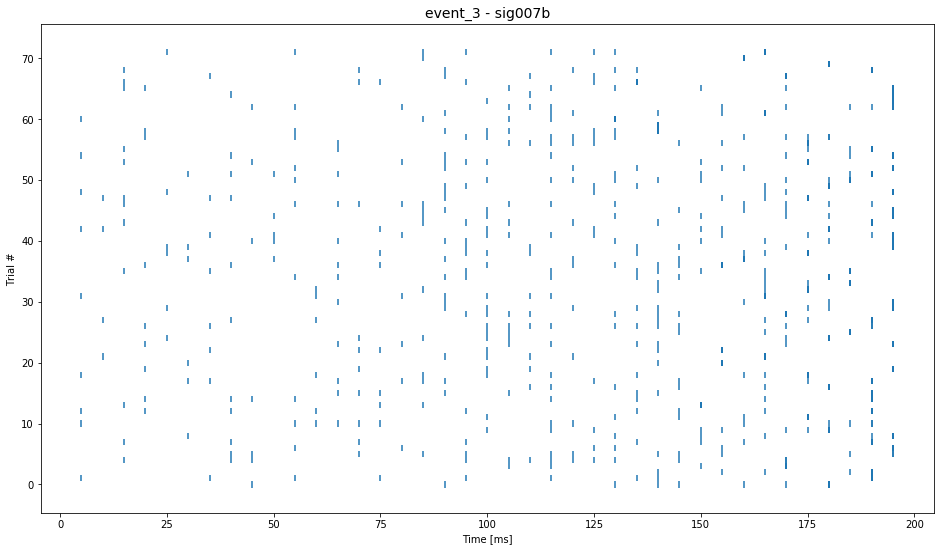

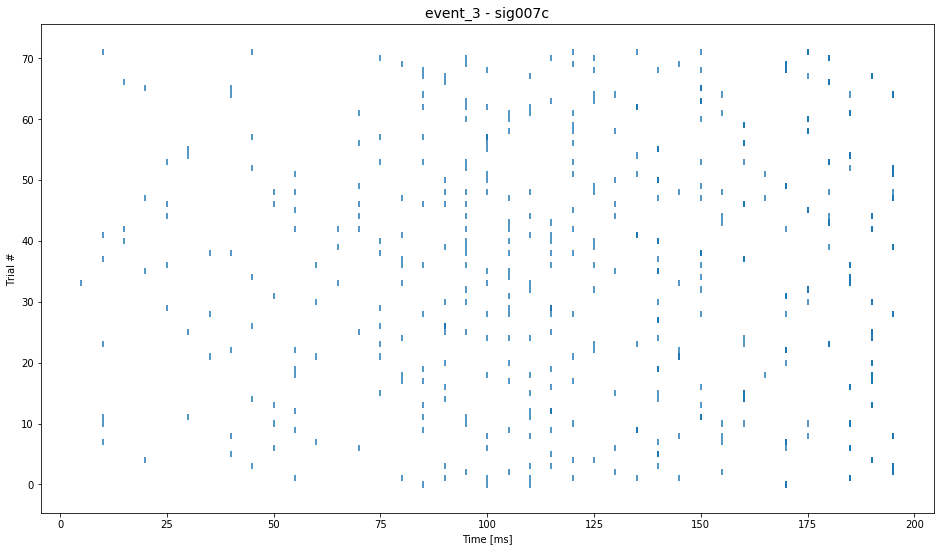

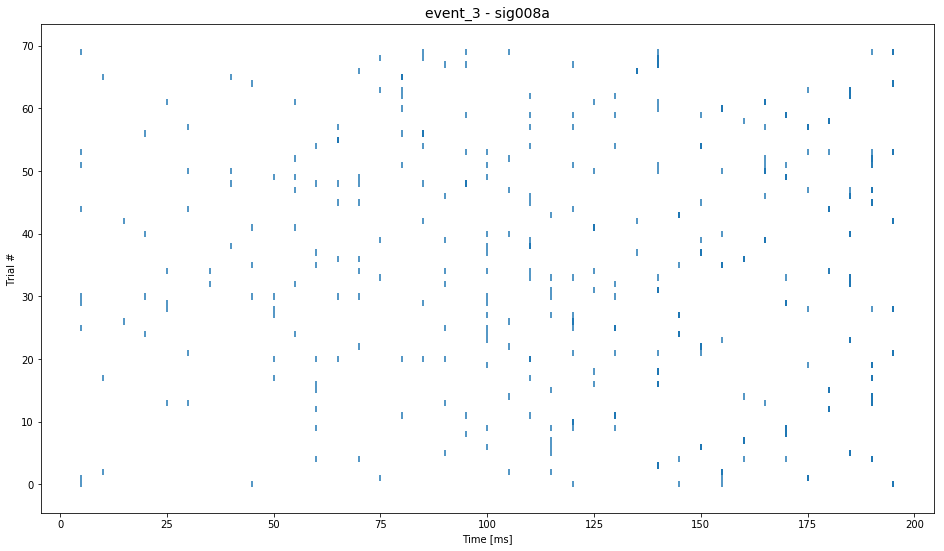

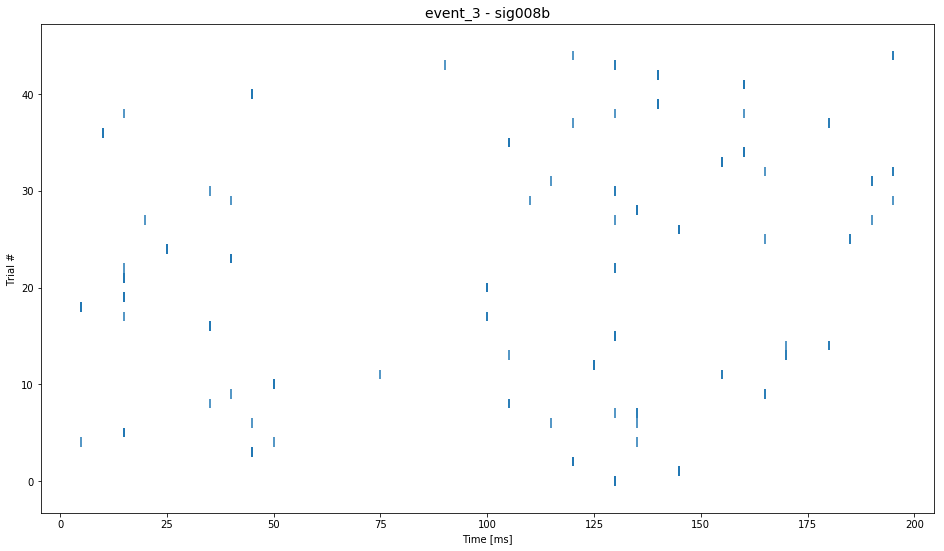

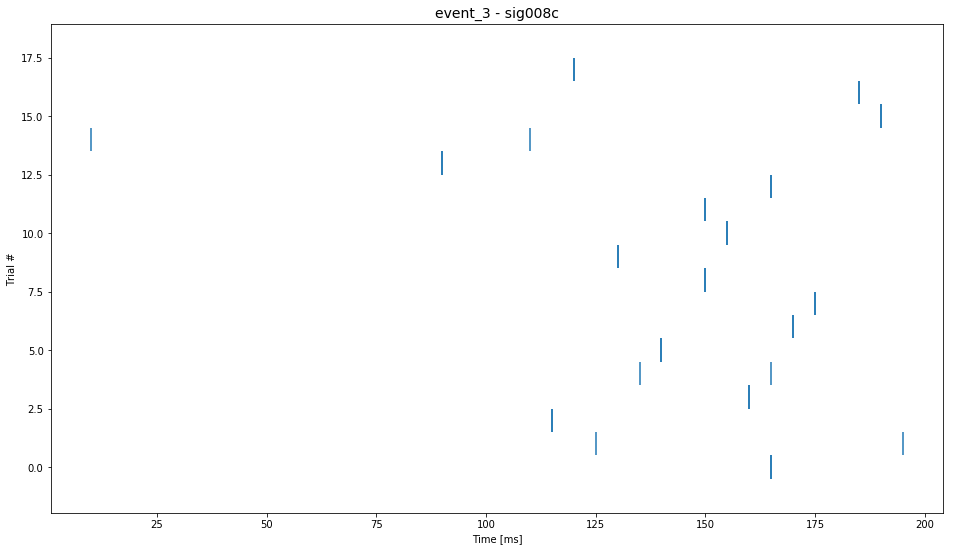

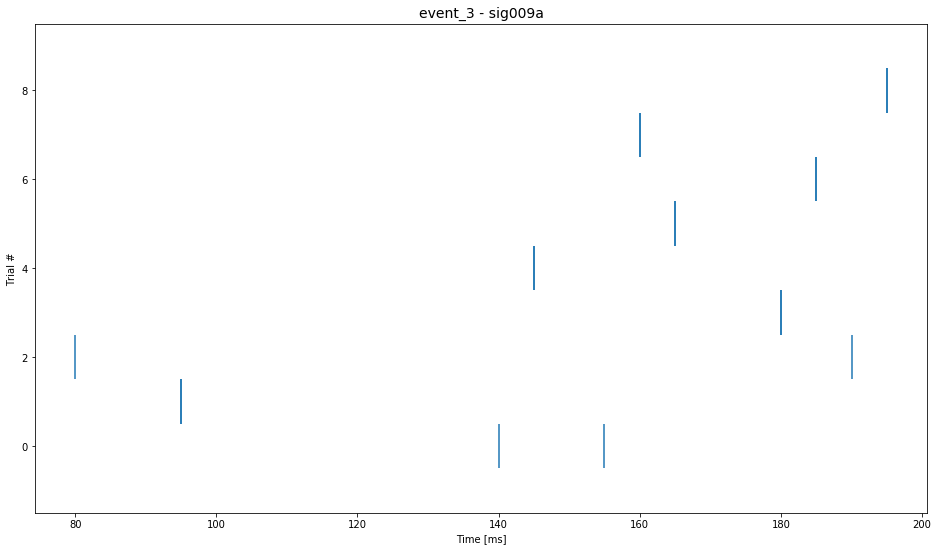

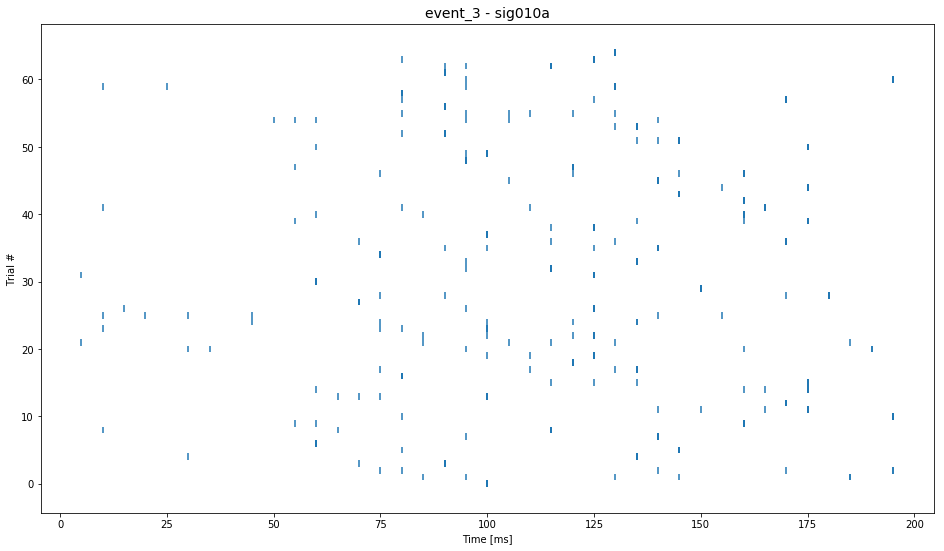

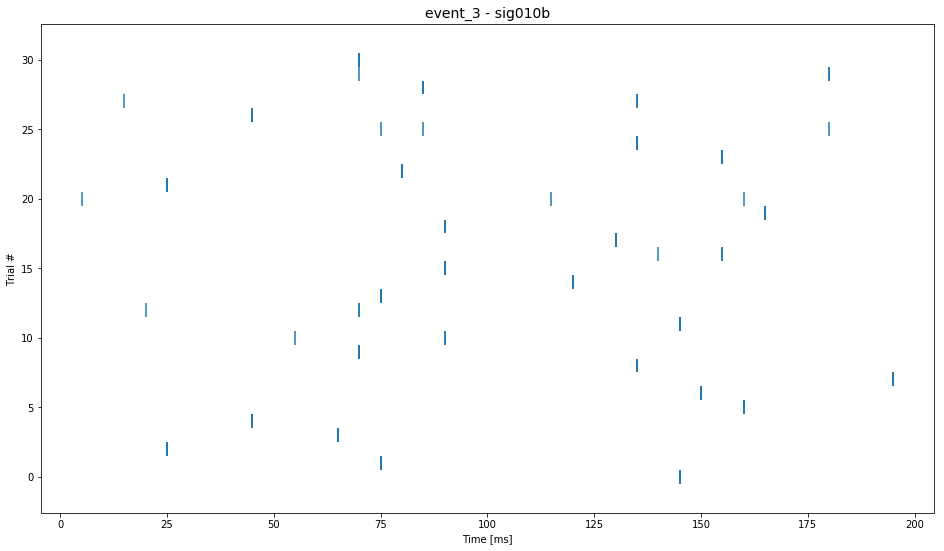

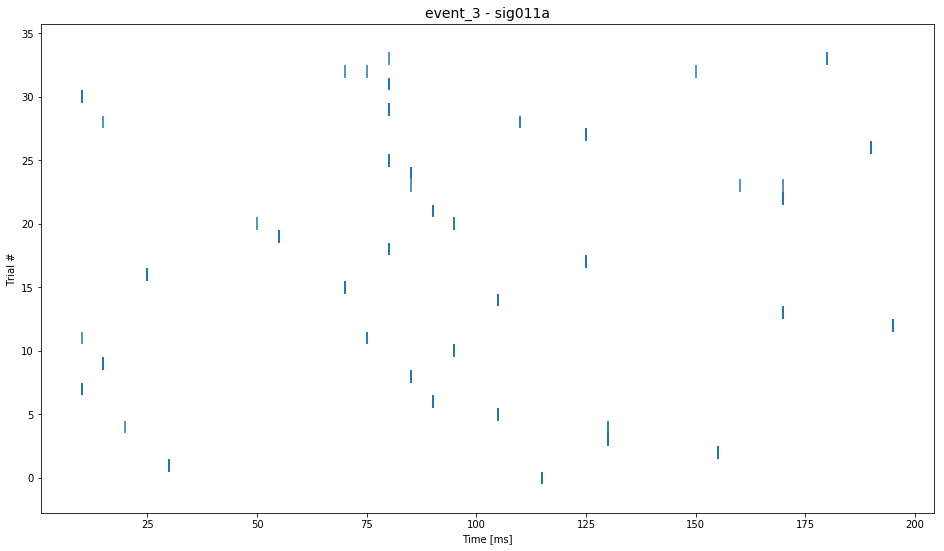

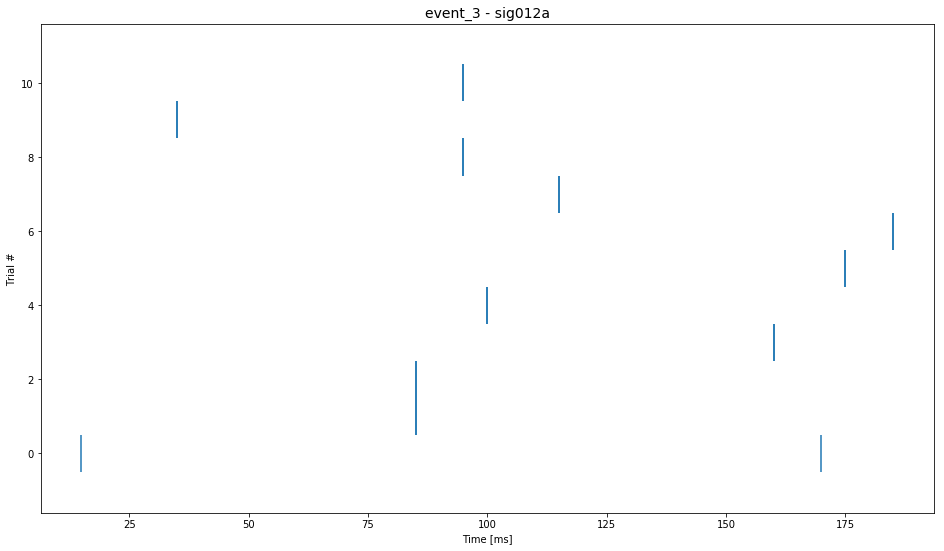

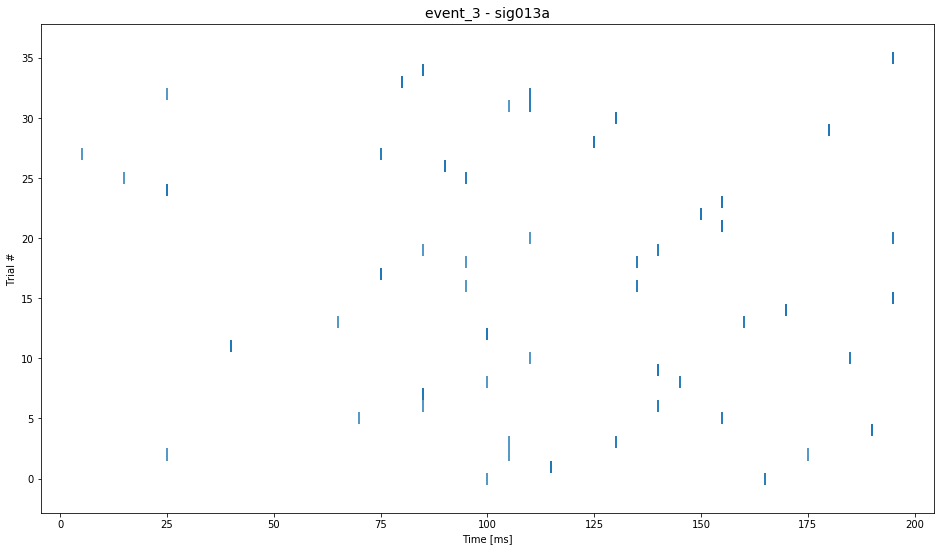

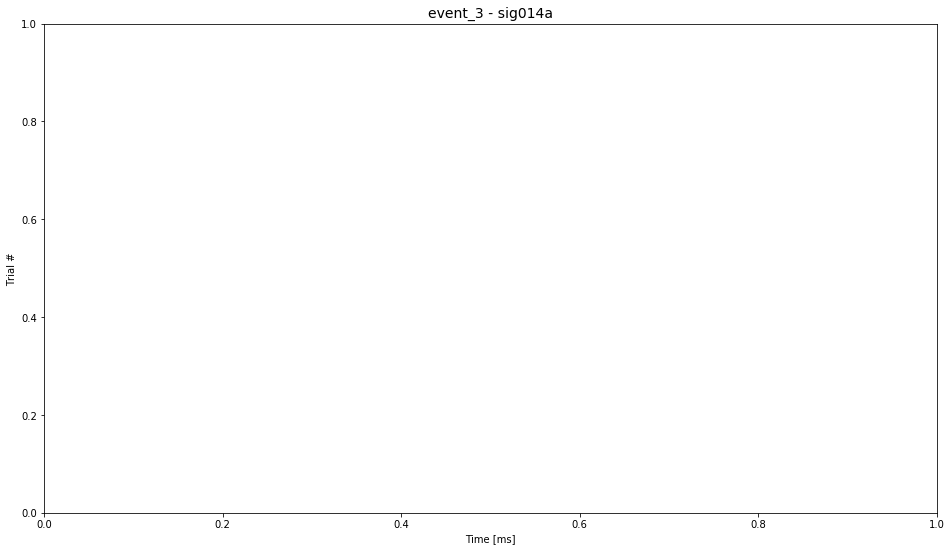

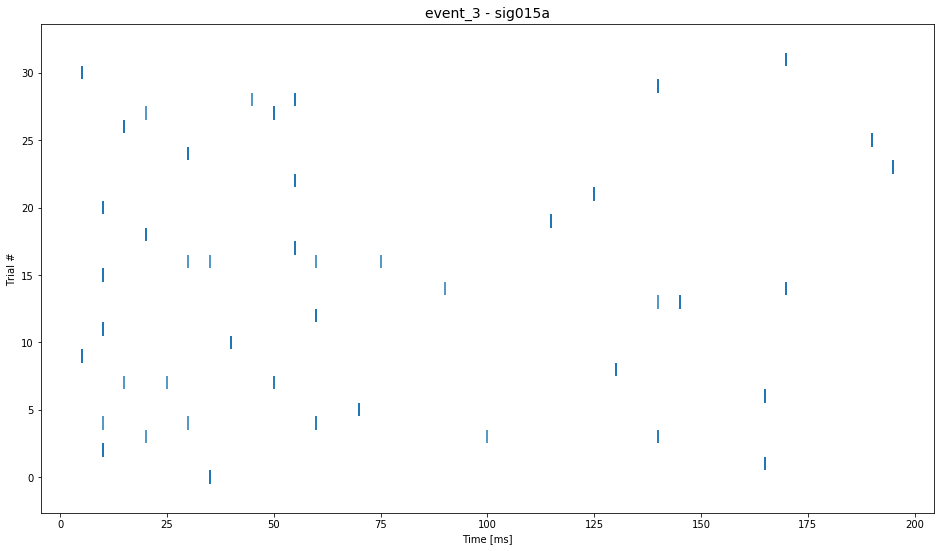

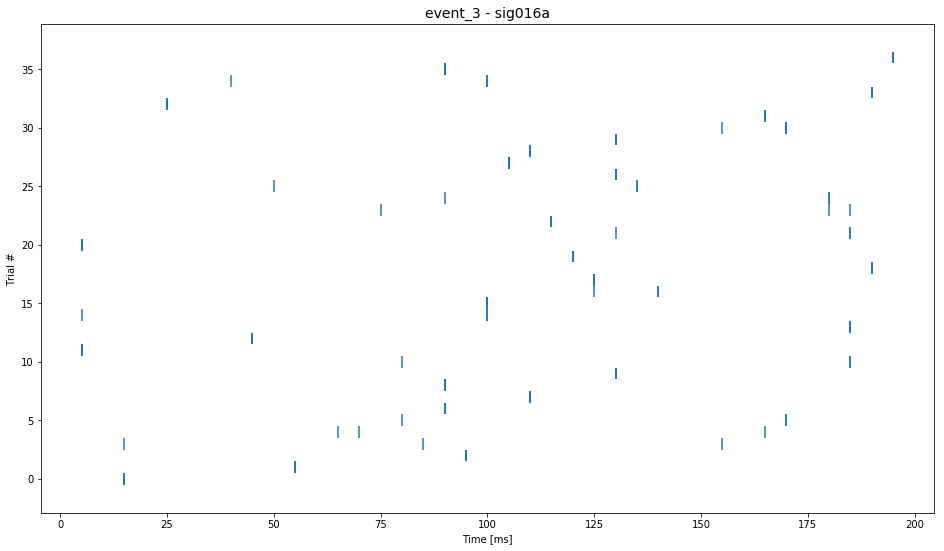

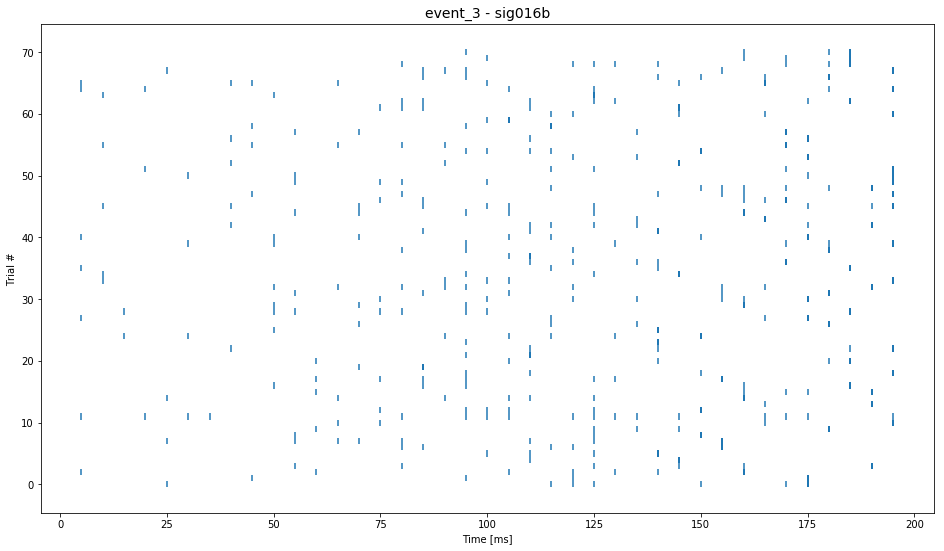

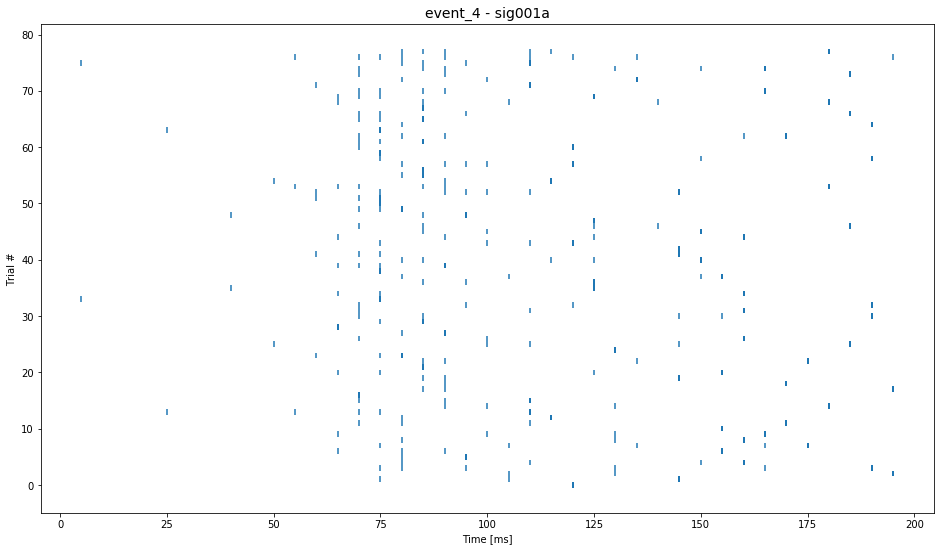

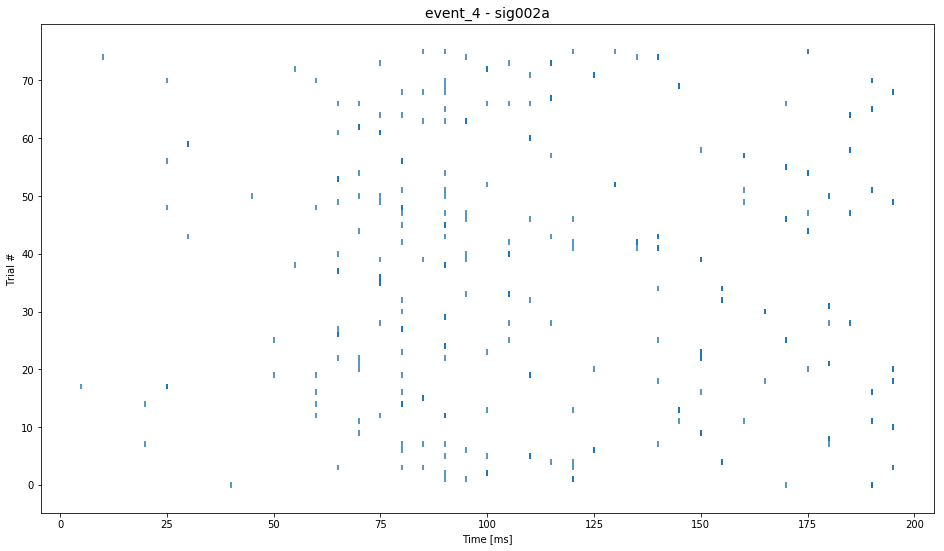

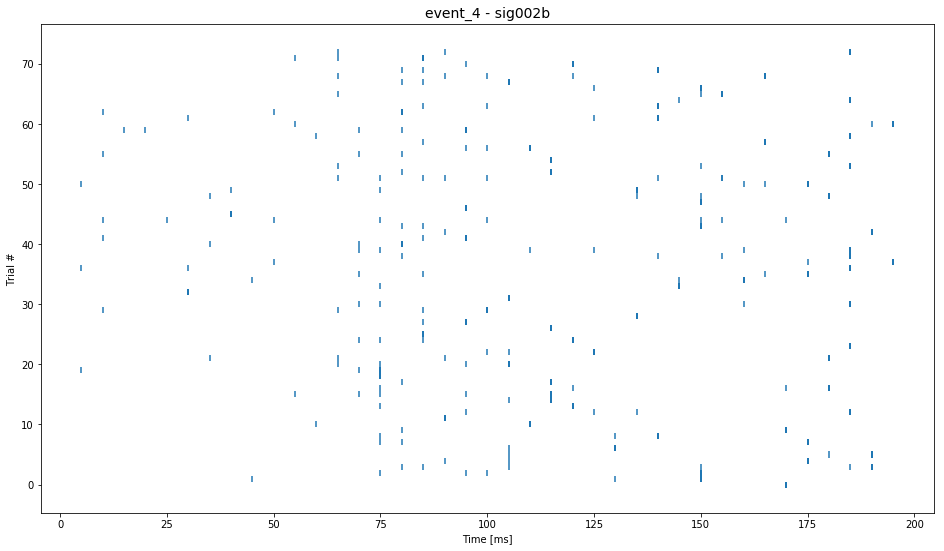

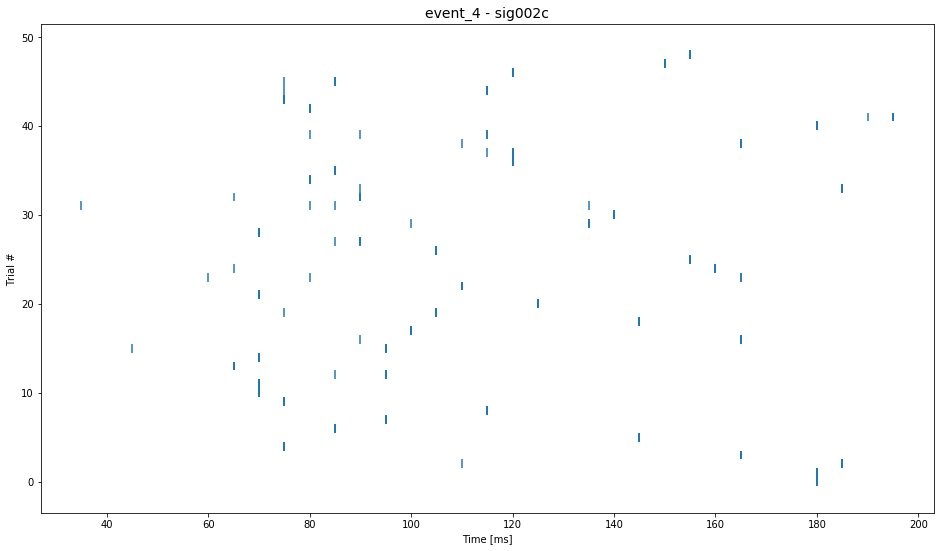

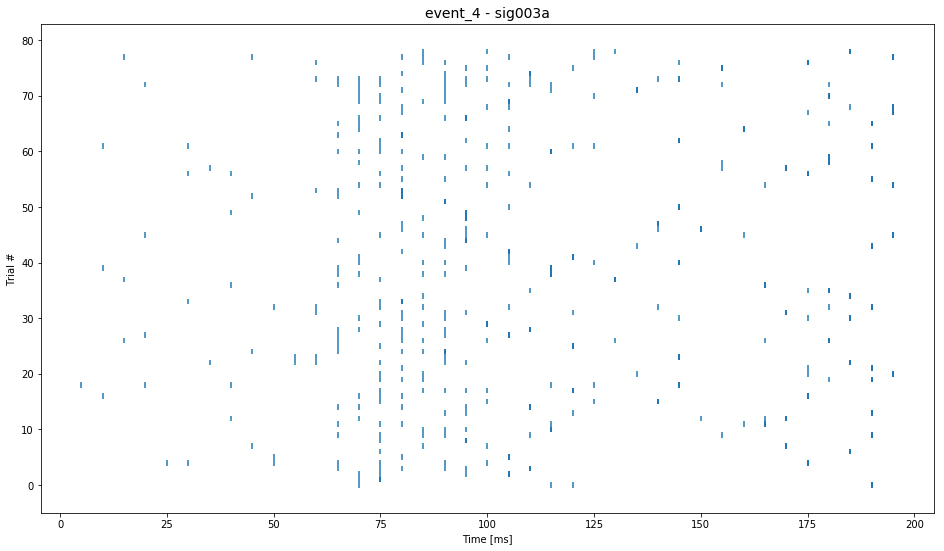

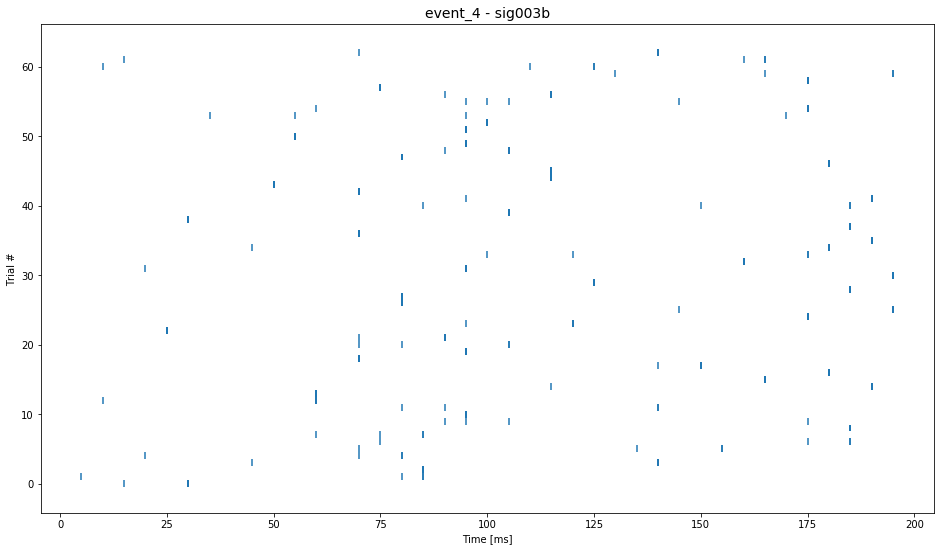

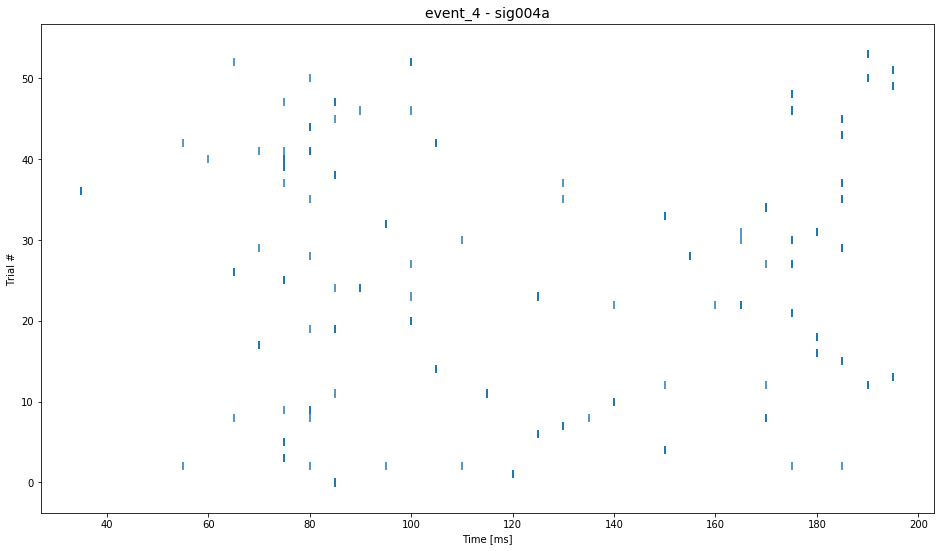

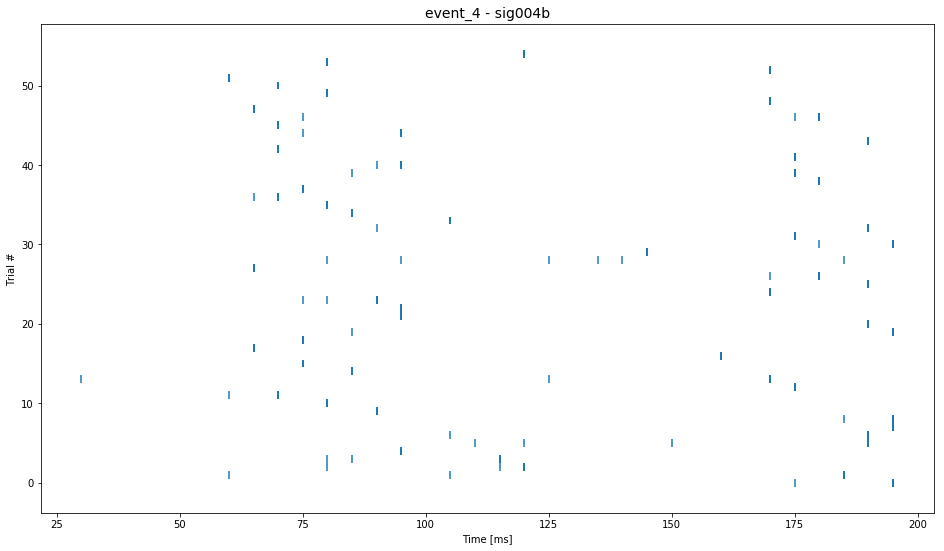

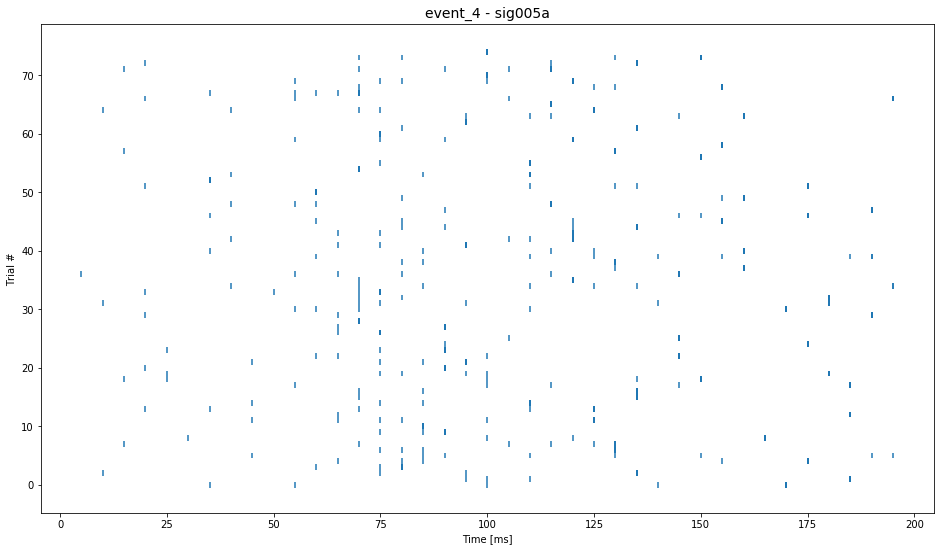

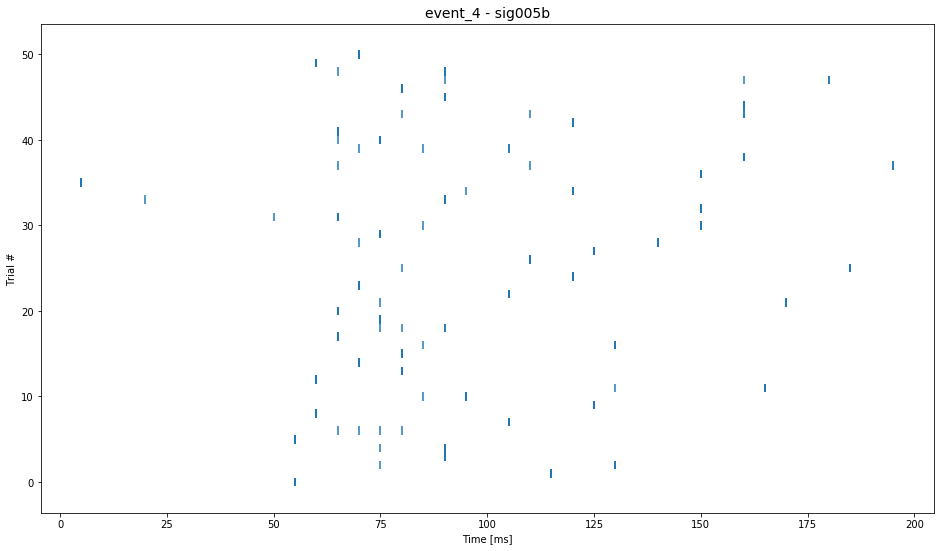

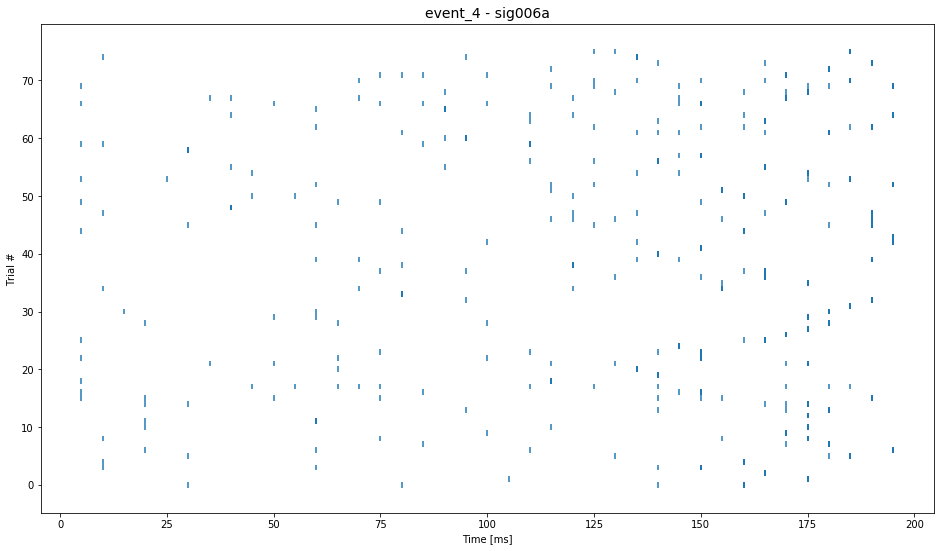

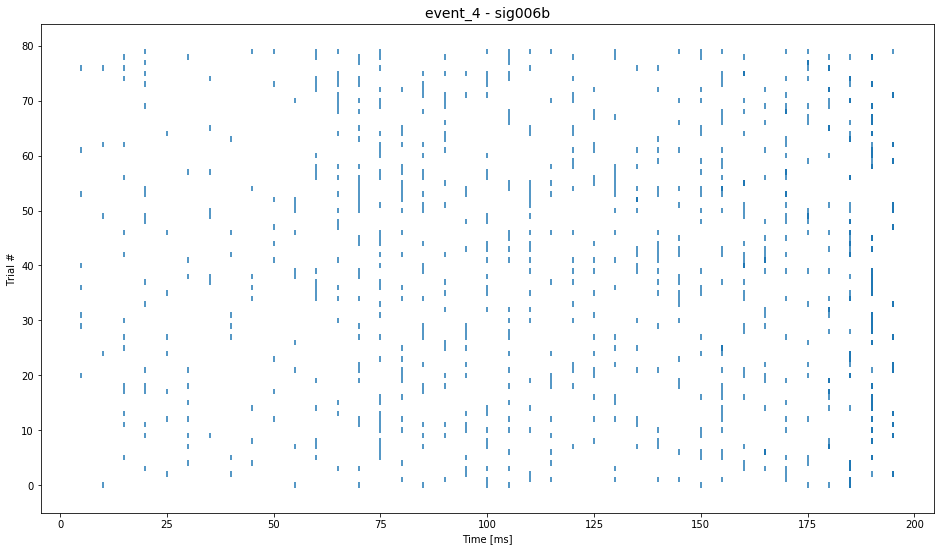

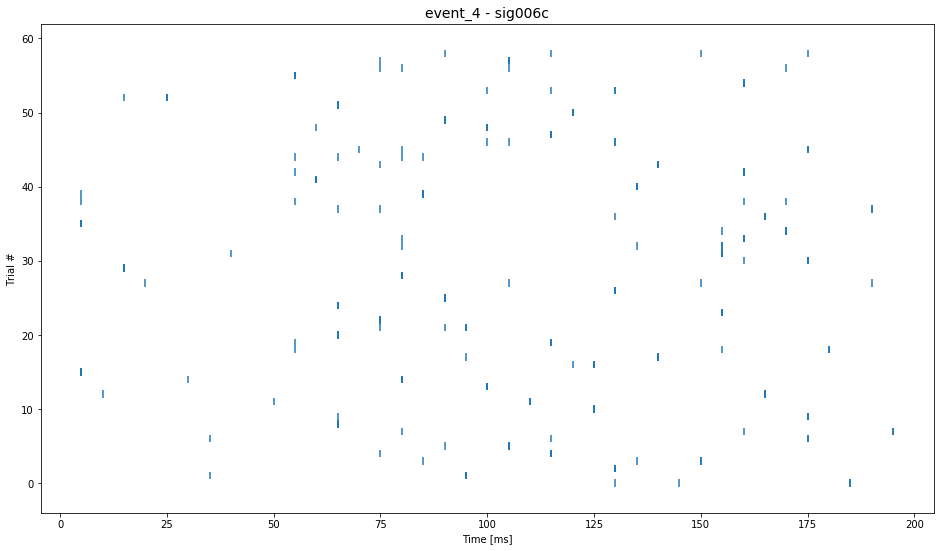

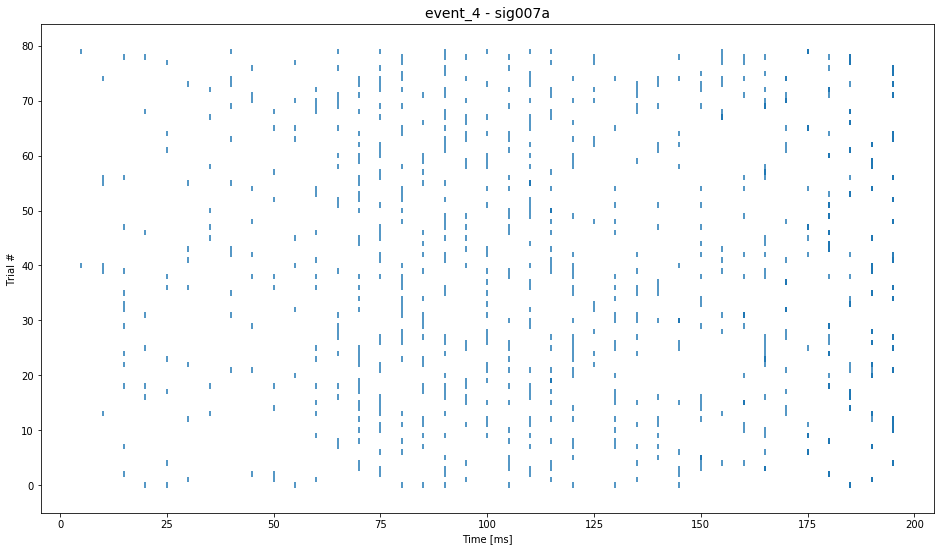

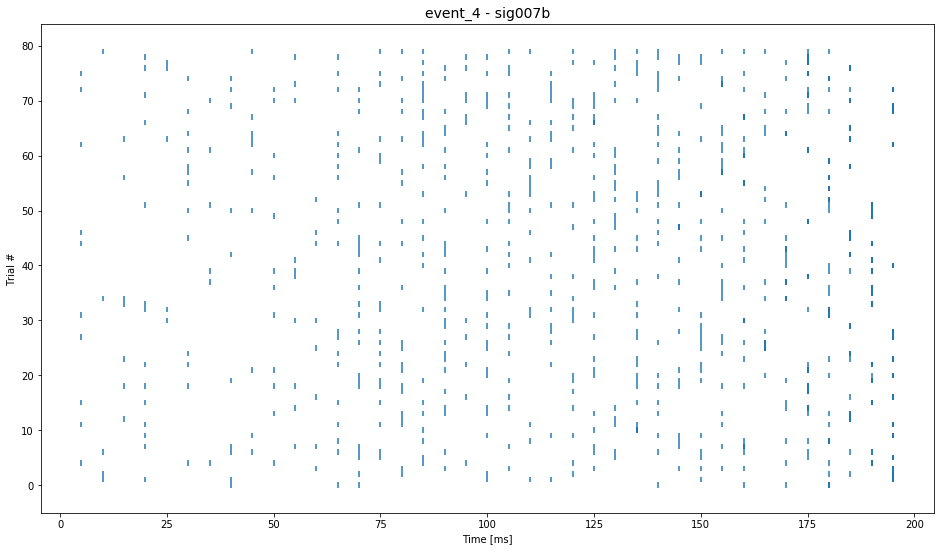

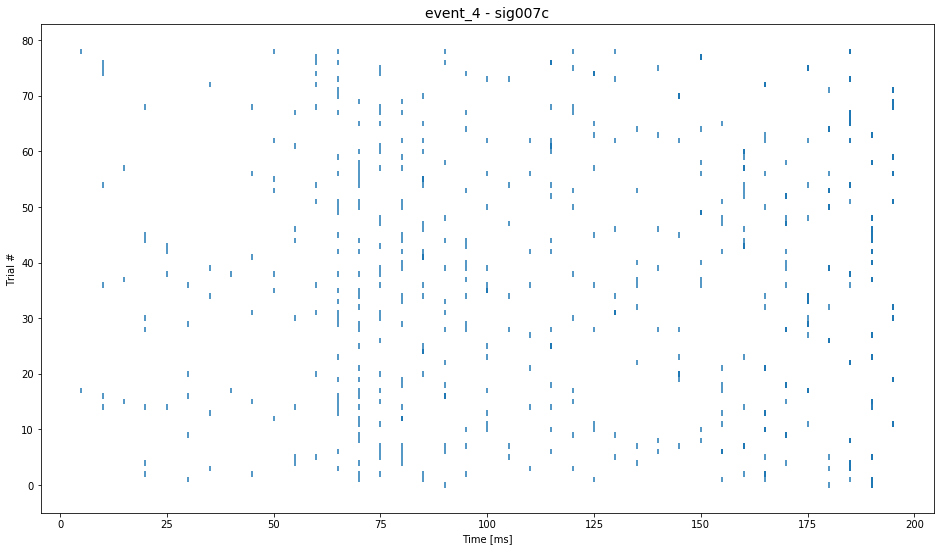

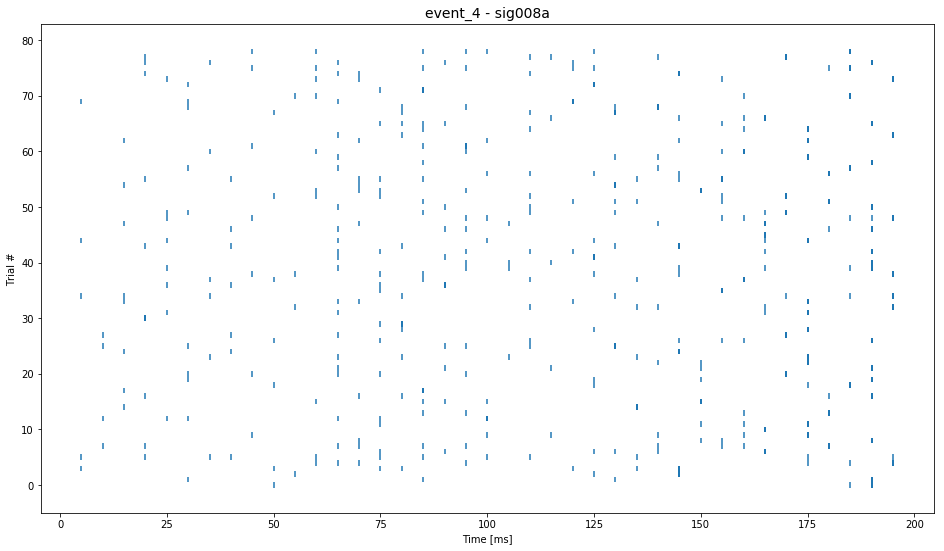

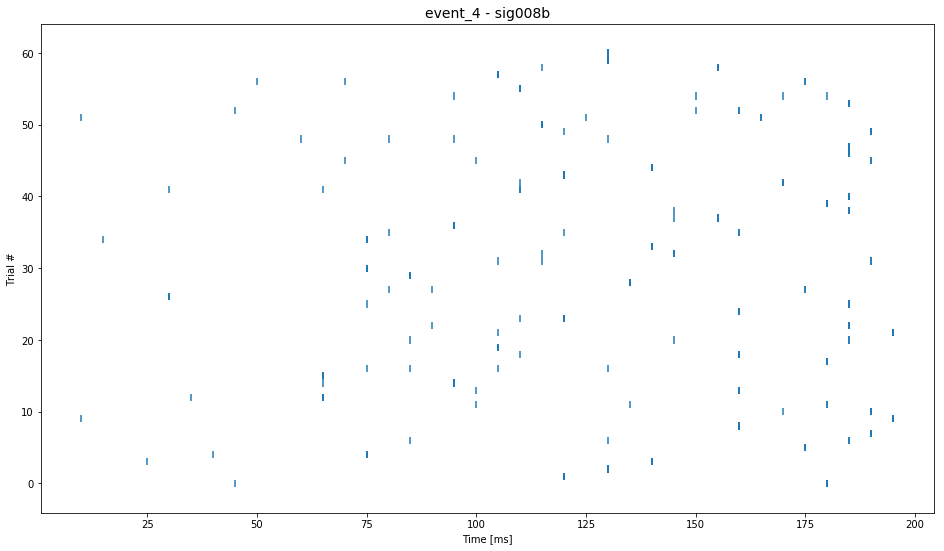

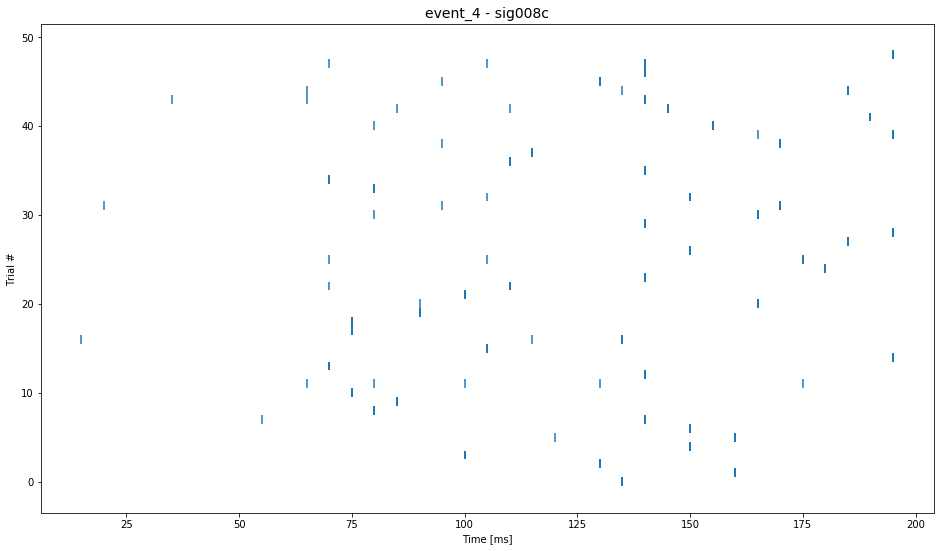

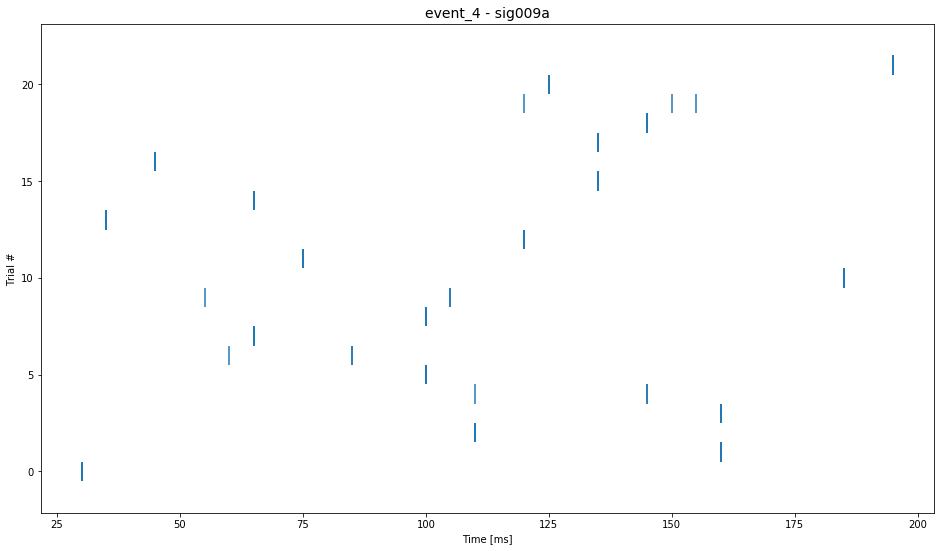

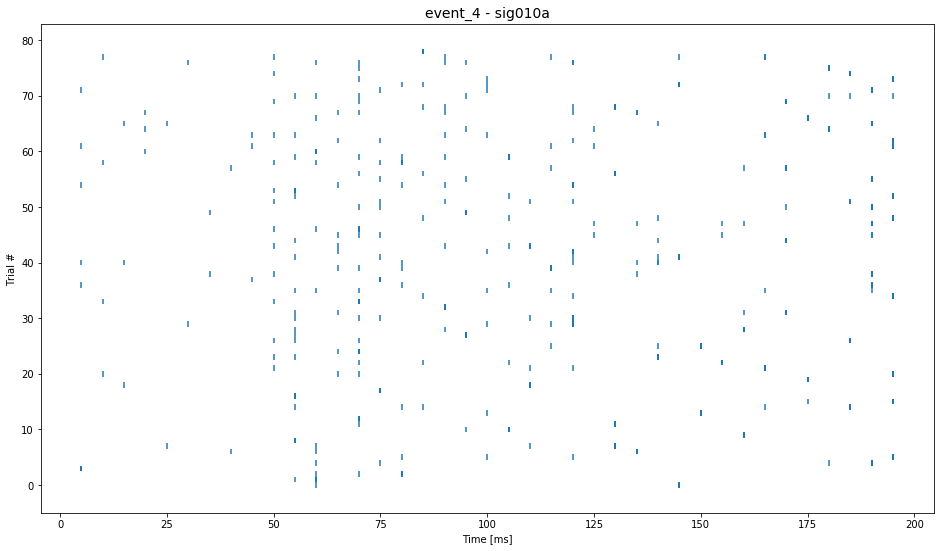

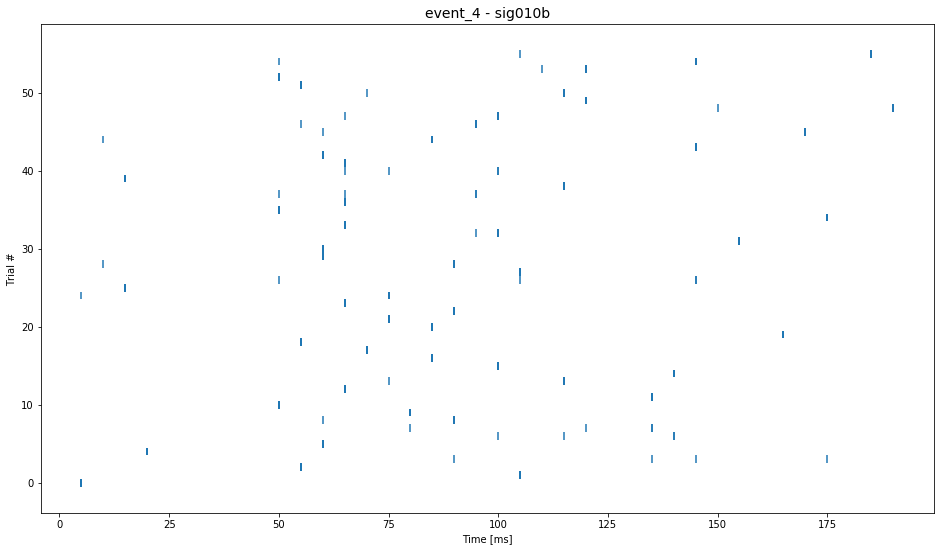

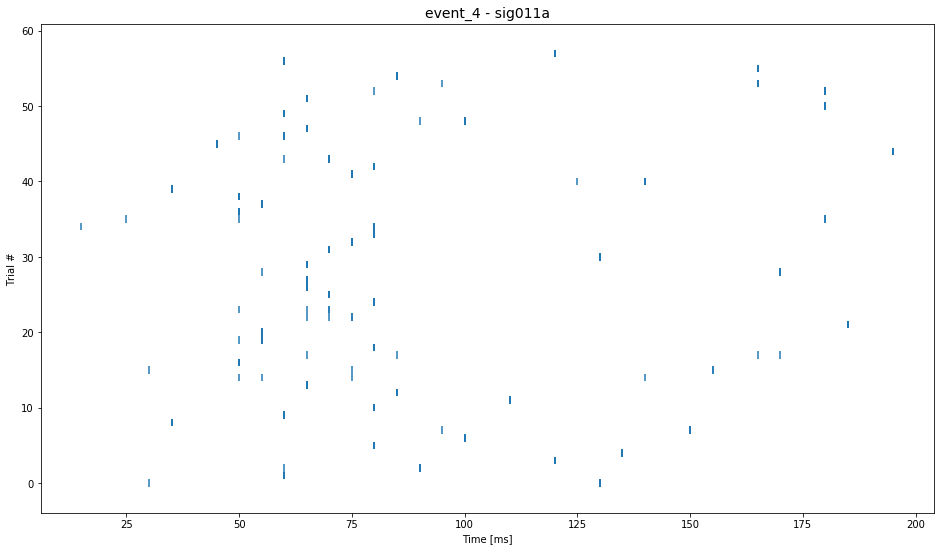

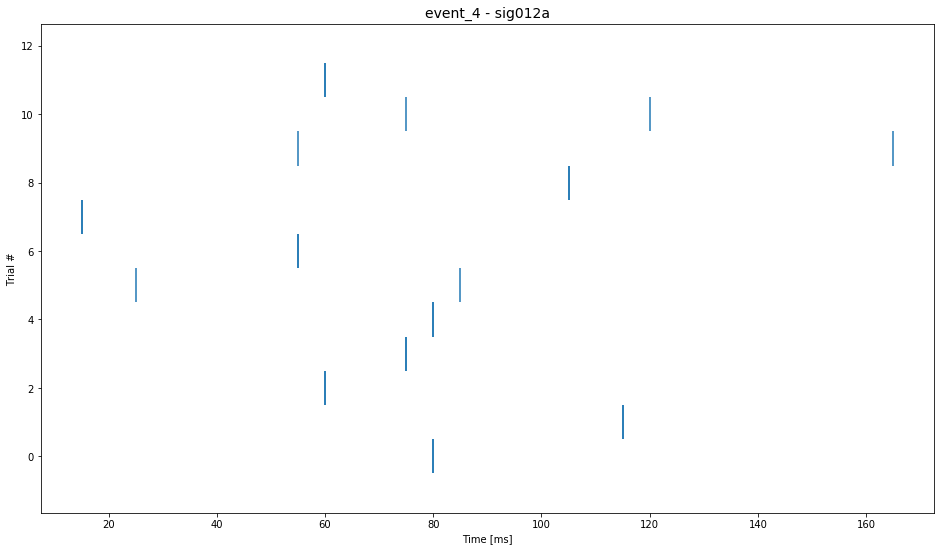

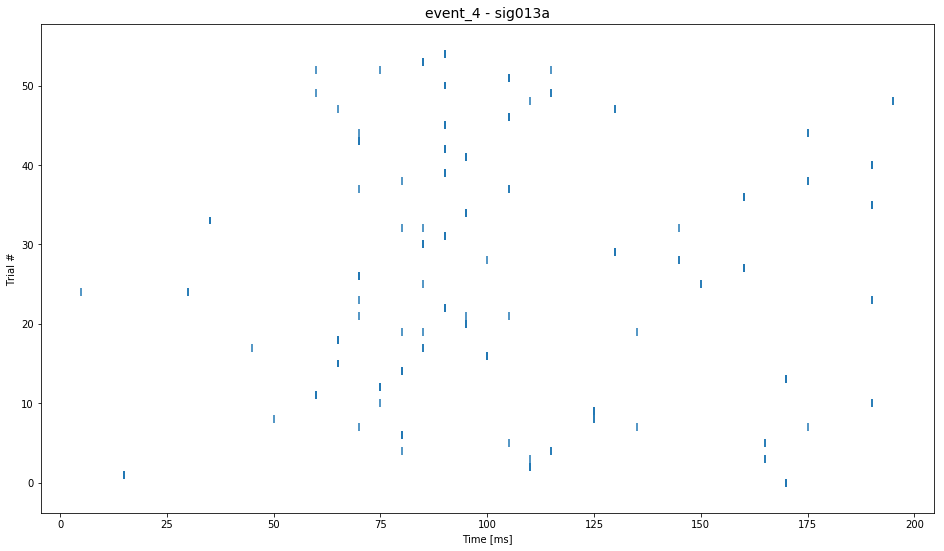

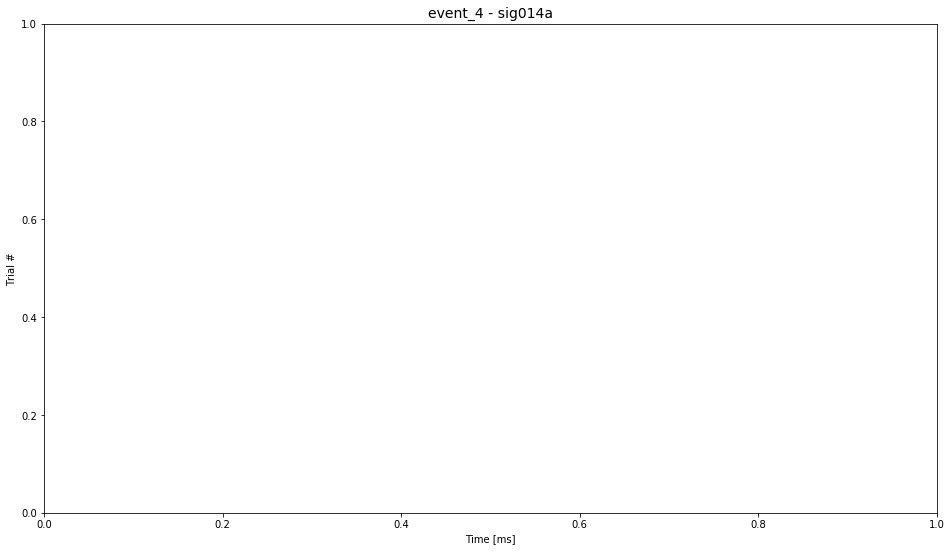

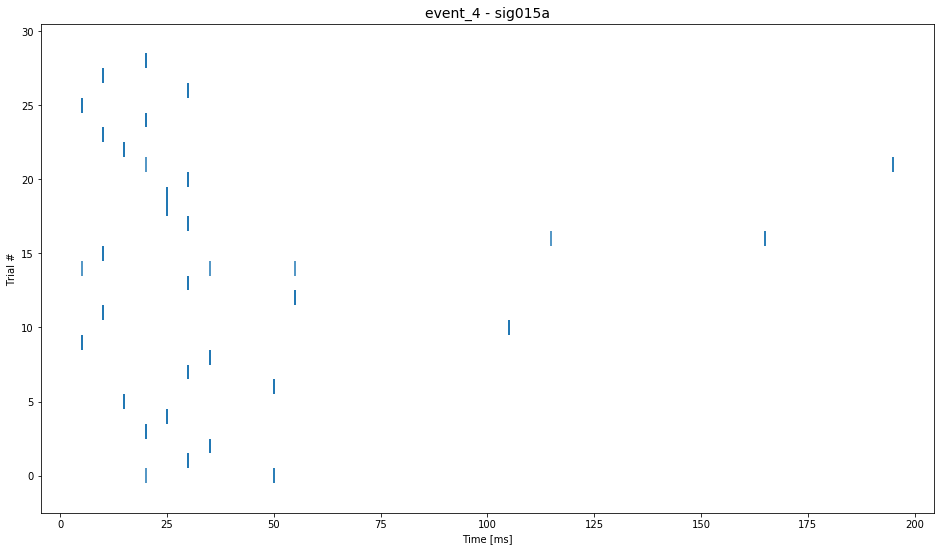

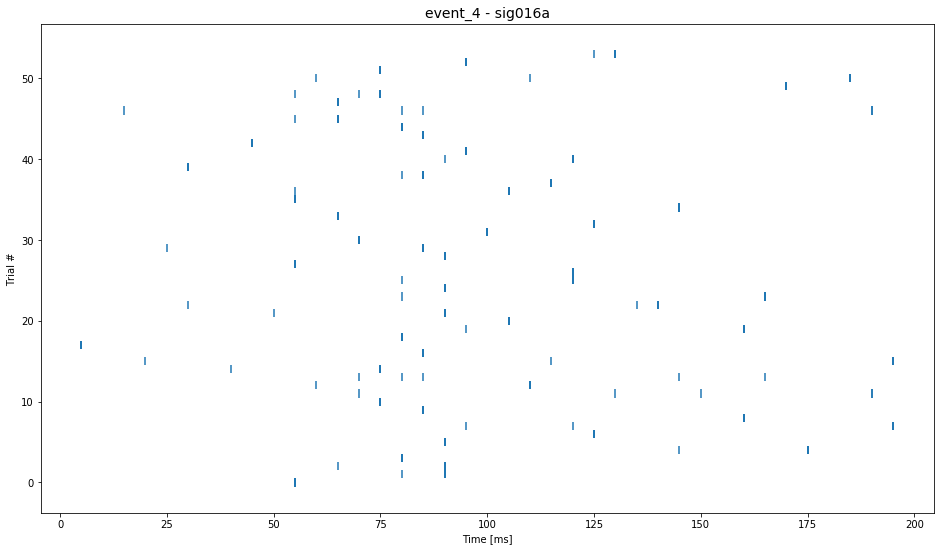

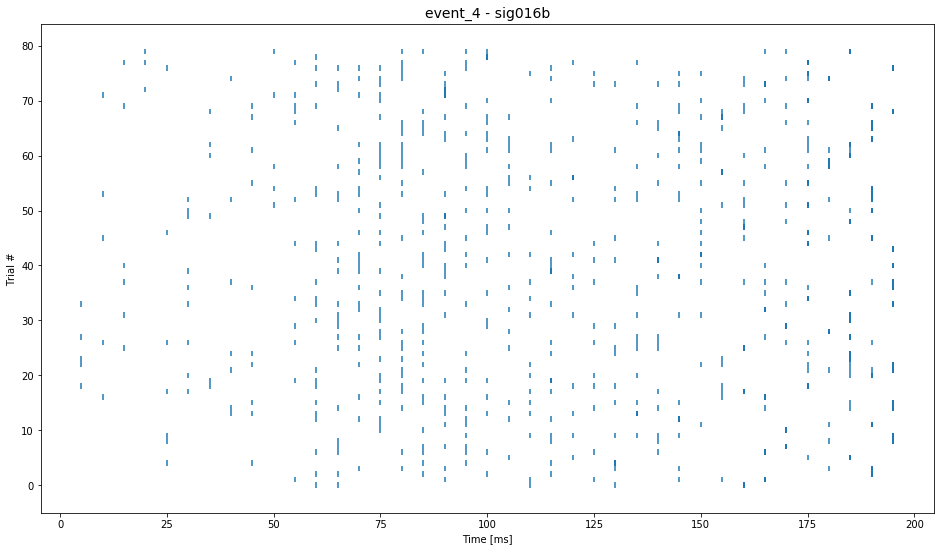

In [11]:
# plot binned response spike rasters
plot_binned_resp(bin_dict,events,neurons,params)

In [13]:
# generate ground-truth psth dict with all trials(need to reformat)
psth_dict = gen_psth(bin_dict,events,neurons,params,fig_params)

In [14]:
# generate single-trial psths and corresponding leave-out template psths
leave_out_dict = gen_single_trial_psths(bin_dict,events,neurons,params)

bin_size: 5
-> event_1
-> event_2
-> event_3
-> event_4
bin_size: 50
-> event_1
-> event_2
-> event_3
-> event_4
bin_size: 200
-> event_1
-> event_2
-> event_3
-> event_4


In [44]:
# label event trials based on ground-truth psths and trial-wise psth templates
[conf_matrices,performance_dict] = event_labels(psth_dict,leave_out_dict,events,neurons,params)

NameError: name 'event_labels' is not defined

In [78]:
prob_dict=mut_info_from_conf(conf_matrices,params)

bin_size: 5
-> mut_info: 0.4804265929831906
bin_size: 50
-> mut_info: 0.8366170888565942
bin_size: 200
-> mut_info: 1.256228168008012


In [81]:
# aggregate function outputs into desired json format
out=dict()
for bin_size in bin_sizes:
    bin_str='bin_{}ms'.format(bin_size)
    out[bin_str]={
                    'performance':performance_dict[bin_size],
                    'confusion_matrix':conf_matrices[bin_size].tolist(),
                    'mutual_info':prob_dict[bin_size]['mut_info']
                    }
    
# write to json
example=0
save=1
if (save):
    if example==1:
        save_str='delRosario_Mason_hw4_example.json'
    else:
        save_str='delRosario_Mason_hw4_results.json'
    jsonfile = open(save_str, "w")
    # magic happens here to make pretty-printed json
    jsonfile.write(json.dumps(out, indent=4, sort_keys=True))
    jsonfile.close()
    print('Output saved to %s' % save_str)

Output saved to delRosario_Mason_hw4_results.json


In [65]:
# sandbox
# -> instantiating zero matrix
# test=np.zeros((10,20))
# print(test)
# -> what's going on with events obj?
# print(events)
# -> see if we can leverage our bin dict object to prevent re-writing code
# test=bin_dict[50]['event_1']['sig002a']['bins']
# test=np.split(test,[0,len(test)-1,len(test)])
# print(np.apply_along_axis(len,axis=0,arr=test))
# print('0: {}'.format(test[0]))
# print('1: {}'.format(test[1]))
# print('2: {}'.format(test[2])) 
# ^^ cool! this is how we will generate trial-wise psths and leave-one-out psths #
# ^^ make sure we account for corner cases (i.e., first and last trial psths)

## what's going on with zeros?
# zeros_temp=np.zeros(40)
# print(zeros_temp)
# print(len(zeros_temp[0]))

## is conf-matrix working?
print(conf_matrices[5])
print(conf_matrices[50])
print(conf_matrices[200])

## is performance_dict working?
print(performance_dict[5])
print(performance_dict[50])
print(performance_dict[200])

[[41.  7. 23.  0.]
 [ 6. 32. 16. 23.]
 [24.  7. 34.  7.]
 [ 0. 33.  5. 42.]]
[[48.  4. 19.  0.]
 [24. 51.  2.  0.]
 [26.  1. 45.  0.]
 [19.  4.  1. 56.]]
[[61.  2.  8.  0.]
 [ 1. 66. 10.  0.]
 [ 3.  8. 61.  0.]
 [ 0.  9.  5. 66.]]
0.49666666666666665
0.6666666666666666
0.8466666666666667


In [ ]:
# pseudocode: will not run!!!

# global vars
pre_time = 0
post_time 200
bin_size_all = [5,50,200]

# for dims: T = trials, N = neurons, B = bins

# psth generation
for event in events:
    # generate psths; previous code should already do this
    psth_dict[event] = sum(relative_response)/event[num_trials] # relative_response dim = T rows x (N x B) cols
    
# true event label
for event in events:
    for trial in trials:
        trial_template = gen_trial_template() # trial template - activity for single trial; 1 row x (N x B) cols
        current_relative_response = gen_cur_rel_resp() # (T-1) rowx x (N x B) cols; leave-one-out
        current_PSTH_template = sum(current_relative_response)/(event[num_trials]-1)
        event_psth_templates = concat_event_psth_templates(psth_dict,current_PSTH_template)
        trial_class = euclidean_distance(trial_template,event_psth_templates)
        true_labels, classified_labels = generate_labels(trial_class) # these are lists which will be used to generate confusion matrix
        
# confusion matrix
    confusion_matrix = [true labels (rows) x classified_labels (cols)] # matrix of counts
    calc_mut_info() # I forget which of these we need...
    calc_entropy() # I forget which of these we need...